In [56]:
!jupyter nbconvert --to slides slides.ipynb && mv slides.slides.html slides.html

# TODO: source map the code?

[NbConvertApp] Converting notebook slides.ipynb to slides
[NbConvertApp] Writing 5391526 bytes to slides.slides.html


# Future improvements

pure slides web-page via [jupyterlite](https://jupyterlite.readthedocs.io/en/latest/quickstart/deploy.html) + [jupyterlab-deck](https://github.com/deathbeds/jupyterlab-deck)

```python
# jupyterlab-deck==0.1.3

%pip install jupyterlab-deck
```

Imports:

In [2]:
import json
import sys

from IPython.display import display, Image, Markdown
import pytest
from pyteal import *
import qrcode
from typing import Literal

`show` object:

In [3]:
Rng = tuple[int, int]

class CodeDisplayer:
    ERROR_NO_RANGES = """Must provide at least one range - 
Why would you want to display NOTHING AT ALL?"""

    ERROR_RANGE_INDEX = "Range[{}] = {} was invalid because not in {}"
    
    def __init__(self):
        self.md: str = ""
    
    def validate(self, lines: list[str], *ranges: Rng) -> None:
        assert ranges, self.ERROR_NO_RANGES
        
        N = len(lines)
        def in_range(lineno):
            return 1 <= lineno <= N
        
        for i, rng in enumerate(ranges):
            assert all(map(in_range, rng)), self.ERROR_RANGE_INDEX.format(i, rng, (1,N))
    
    def prepare(self, code: str, *ranges: Rng, segment_buffer: bool = False) -> None:
        """Prepare for displaying code based on Human line numbers"""
        lines = code.splitlines()
        self.validate(lines, *ranges)
        NL = "\n"
        BUFF = NL if segment_buffer else ""
        def segment(r):
            return f"{BUFF}{NL.join(lines[i] for i in r)}{BUFF}"

        body = "\n. . .\n".join(segment(range(first-1, last)) for first, last in ranges)
        self.md = "```\n" + body + "\n```"

    def __call__(self):
        return display(Markdown(self.md))
        
show = CodeDisplayer()

def test_example():
    ae = None
    def aerr(s):
        assert s in str(ae.value)

    show.validate([1, 2, 3], (2,3))
    show.validate([1, 2, 3], (2,3), (1,3))
    show.validate([1, 2, 3], (2,3), (1,1), (1,3))

    with pytest.raises(AssertionError) as ae:
        show.validate([1, 2, 3])
    aerr("NOTHING AT ALL?")

    with pytest.raises(AssertionError) as ae:
        show.validate([1, 2, 3], (2, 4))
    aerr("Range[0] = (2, 4) was invalid because not in (1, 3)")

    with pytest.raises(AssertionError) as ae:
        show.validate([1, 2, 3], (0, 2))
    aerr("Range[0] = (0, 2) was invalid because not in (1, 3)")

    with pytest.raises(AssertionError) as ae:
        show.validate([1, 2, 3], (1,3), (0, 2))
    aerr("Range[1] = (0, 2) was invalid because not in (1, 3)")
    
test_example()

Generate QR-Code for Demo: 

In [4]:
DEMO_URL = "https://jasonpaulos.github.io/decipher-22-pyteal-talk/"
DEMO_QR_CODE = "images/demo-url.png"

qr = qrcode.QRCode(version=1, box_size=8, border=5)
qr.add_data(DEMO_URL)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save(DEMO_QR_CODE)

`ImageDisplayer` objects:

In [5]:
class ImageDisplayer:    
    def __init__(self, img):
        self.img = img
    
    def __call__(self):
        return display(self.img)

# prep the images
img = Image(filename="images/moe.png", alt="Moe of the 3 Stooges", width="400")
moe = ImageDisplayer(img)

img = Image(filename="images/warning.jpeg", alt="Warning", width="200")
warning = ImageDisplayer(img)

img = Image(filename=DEMO_QR_CODE, alt="Demo URL QR-Code")
demo_qr_code = ImageDisplayer(img)

## New in PyTeal: Boxes and ABI-Compatible Smart Contracts
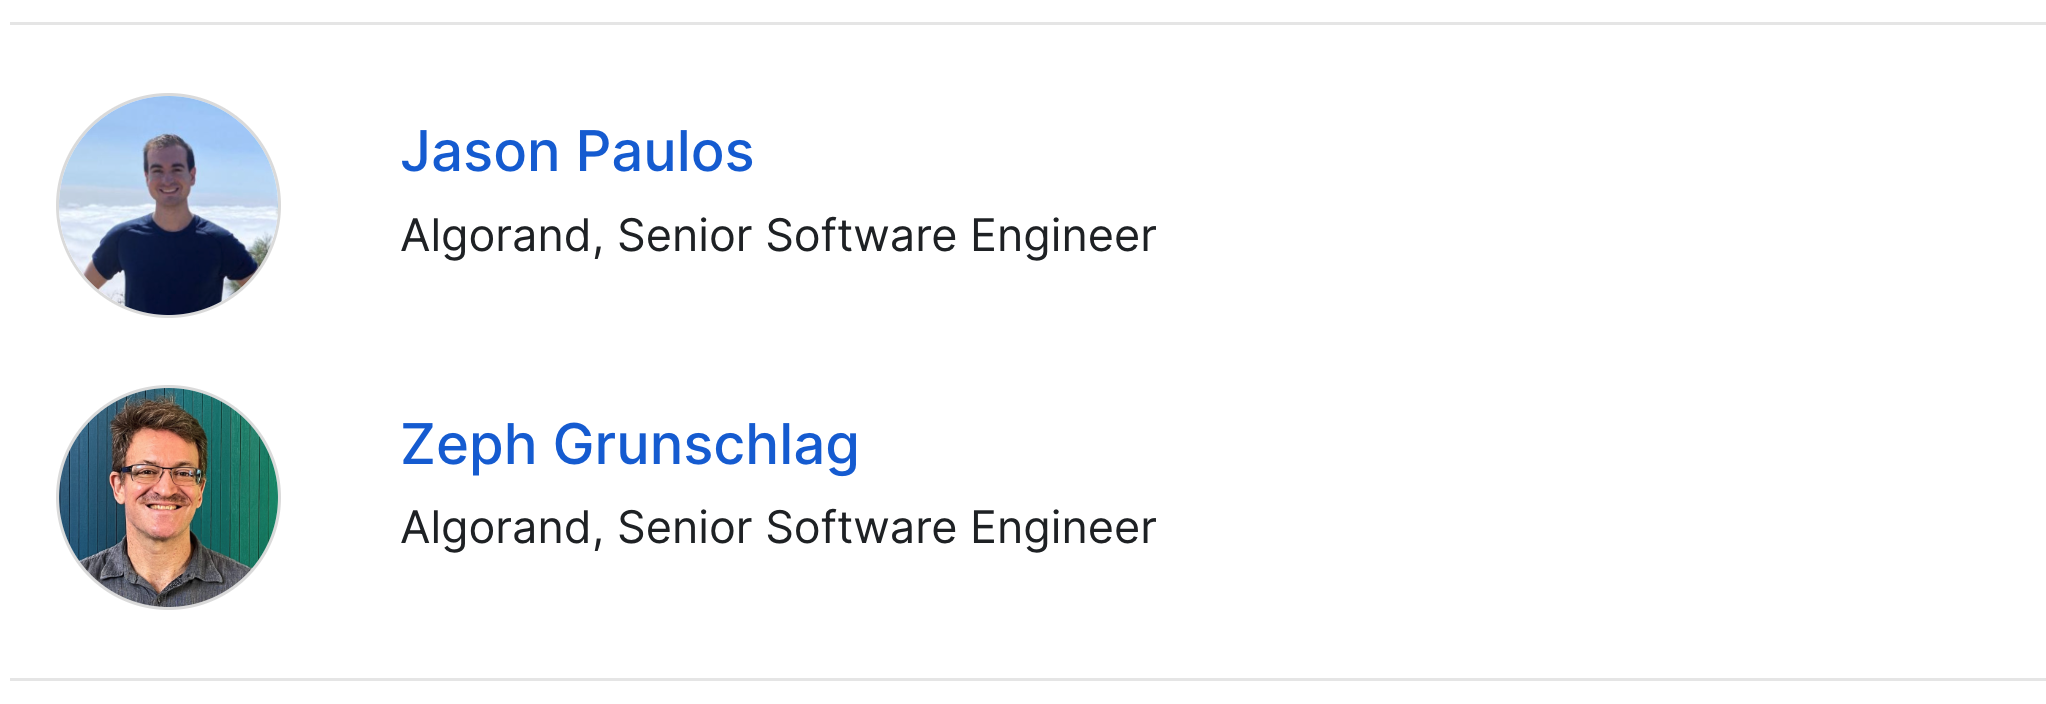
### Learn how to utilize unlimited global storage and ABI-compatibility in PyTeal, Algorand’s library for writing smart contracts in Python.

<!-- Assumed slide numbers
2. Intro Slide
10. Boxes Slide
13. Router Slide
22. Demo Slide
-->
<!-- TODO:
QR codes 
-->

## <center>Agenda</center>

### I. <a href="#/2">Algorand's PyTeal</a>
### II. <a href="#/10">Application Boxes in PyTeal</a>
### III. <a href="#/13">PyTeal's ABI-Router: Building an ARC-4 Application</a>
### IV. <a href="#/22">Demo</a>
### V. Questions



<h1 style='color:white'>.</h1>

### <center>Links</center>
* Decipher 2022: `github.com/jasonpaulos/decipher-22-pyteal-talk`
    * [Repo](https://github.com/jasonpaulos/decipher-22-pyteal-talk/) including these `slides.html` (and `slides.ipynb`)
    * React App [Demo](https://jasonpaulos.github.io/decipher-22-pyteal-talk/)
* Decipher 2021: **Writing Smart Contracts with Python**
    * [Slides](https://docs.google.com/presentation/d/1EStEcLtrsRUctGolTjov6VtE_KGb9cIX)
    * [Video](https://www.youtube.com/watch?v=XKOEYTMKuFc)
* PyTeal's ReadTheDocs: [Box Storage](https://pyteal.readthedocs.io/en/stable/state.html?highlight=box#box-storage), [Bare App Calls](https://pyteal.readthedocs.io/en/stable/abi.html#registering-bare-app-calls), [ABI Types](https://pyteal.readthedocs.io/en/stable/abi.html#definitions)
* Algorand Developer Portal
    * [Application Call Transactions](https://developer.algorand.org/docs/get-details/transactions/transactions/#application-call-transaction)
    * [`OnComplete` Actions](https://developer.algorand.org/docs/get-details/dapps/avm/teal/specification/#oncomplete)
    * [Smart Contract Storage: Boxes](https://developer.algorand.org/articles/smart-contract-storage-boxes/)
* [ARC-4](https://arc.algorand.foundation/ARCs/arc-0004)
* `go-algorand` repo: [Box OpCodes](https://github.com/algorand/go-algorand/blob/bac4117709063bfd48940cc701a72ee60bf19320/data/transactions/logic/TEAL_opcodes.md?plain=1#L1417-L1477), [AVM-8 params](https://github.com/algorand/go-algorand/blob/995ae47e80c50e7632034cac8a70b7d6434d03e3/config/consensus.go#L1235)
* Beaker: [Hello Beaker](https://developer.algorand.org/articles/hello-beaker/), [github](https://github.com/algorand-devrel/beaker)



<h1 style='color:white'>.</h1>

# <center>Algorand's PyTeal</center>



<h1 style='color:white'>.</h1>

### <center>Algorand dApp Layers</center>

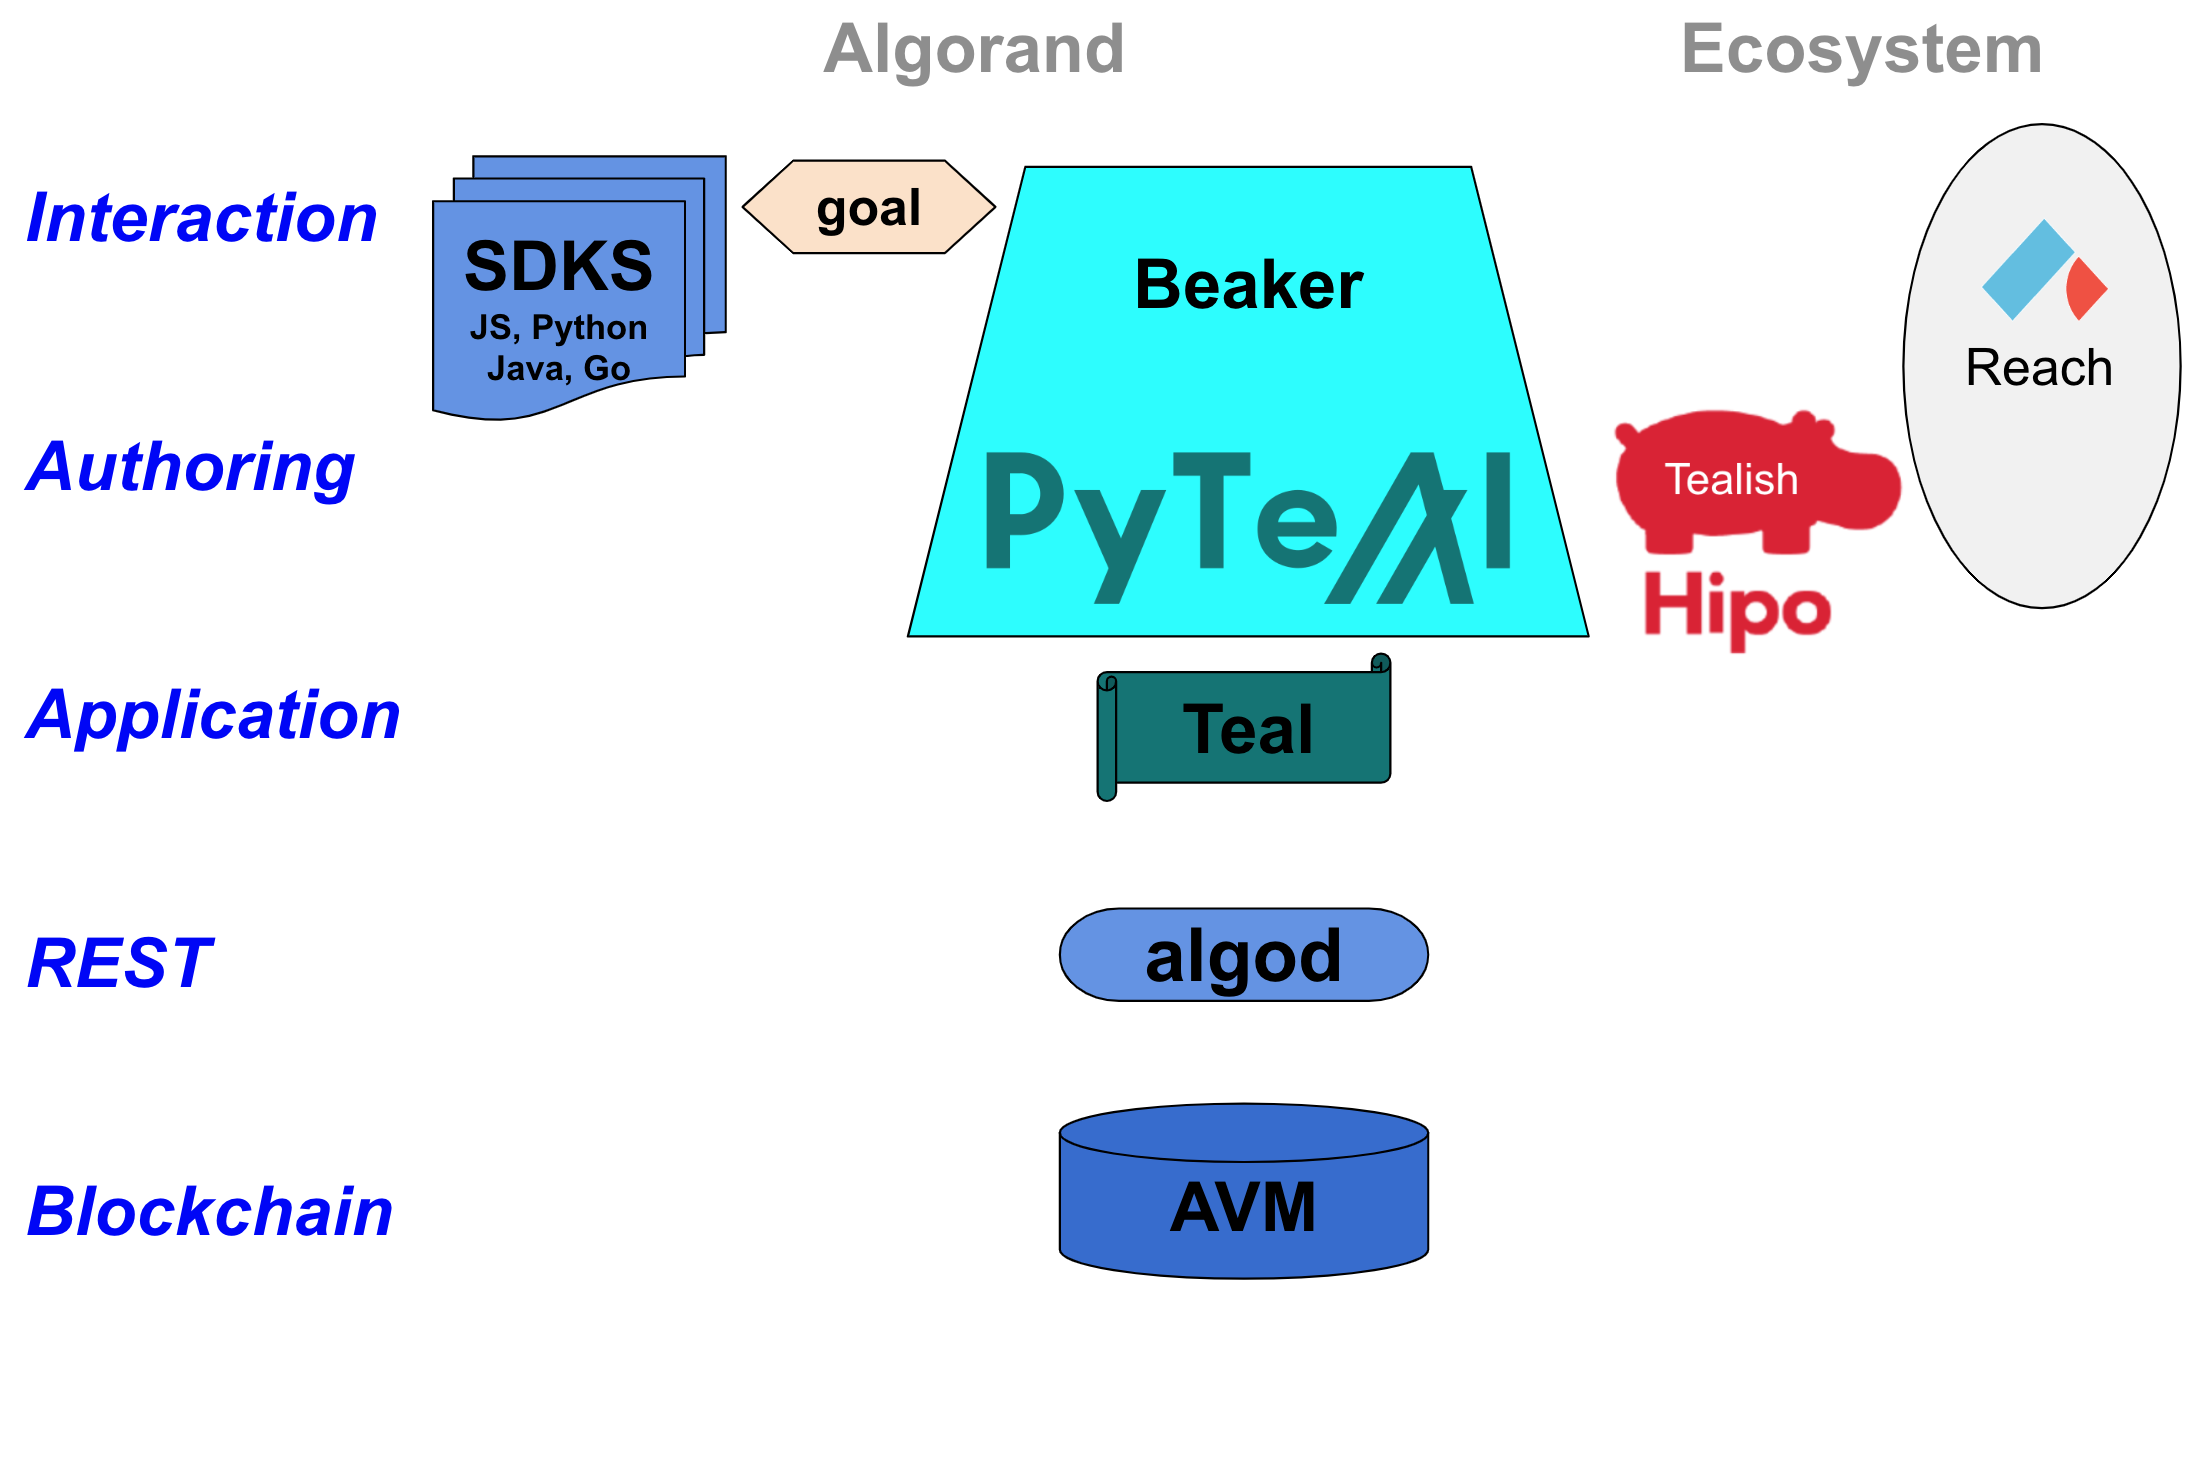

### PyTeal: Boxes and ABI-Compatible Smart Contracts

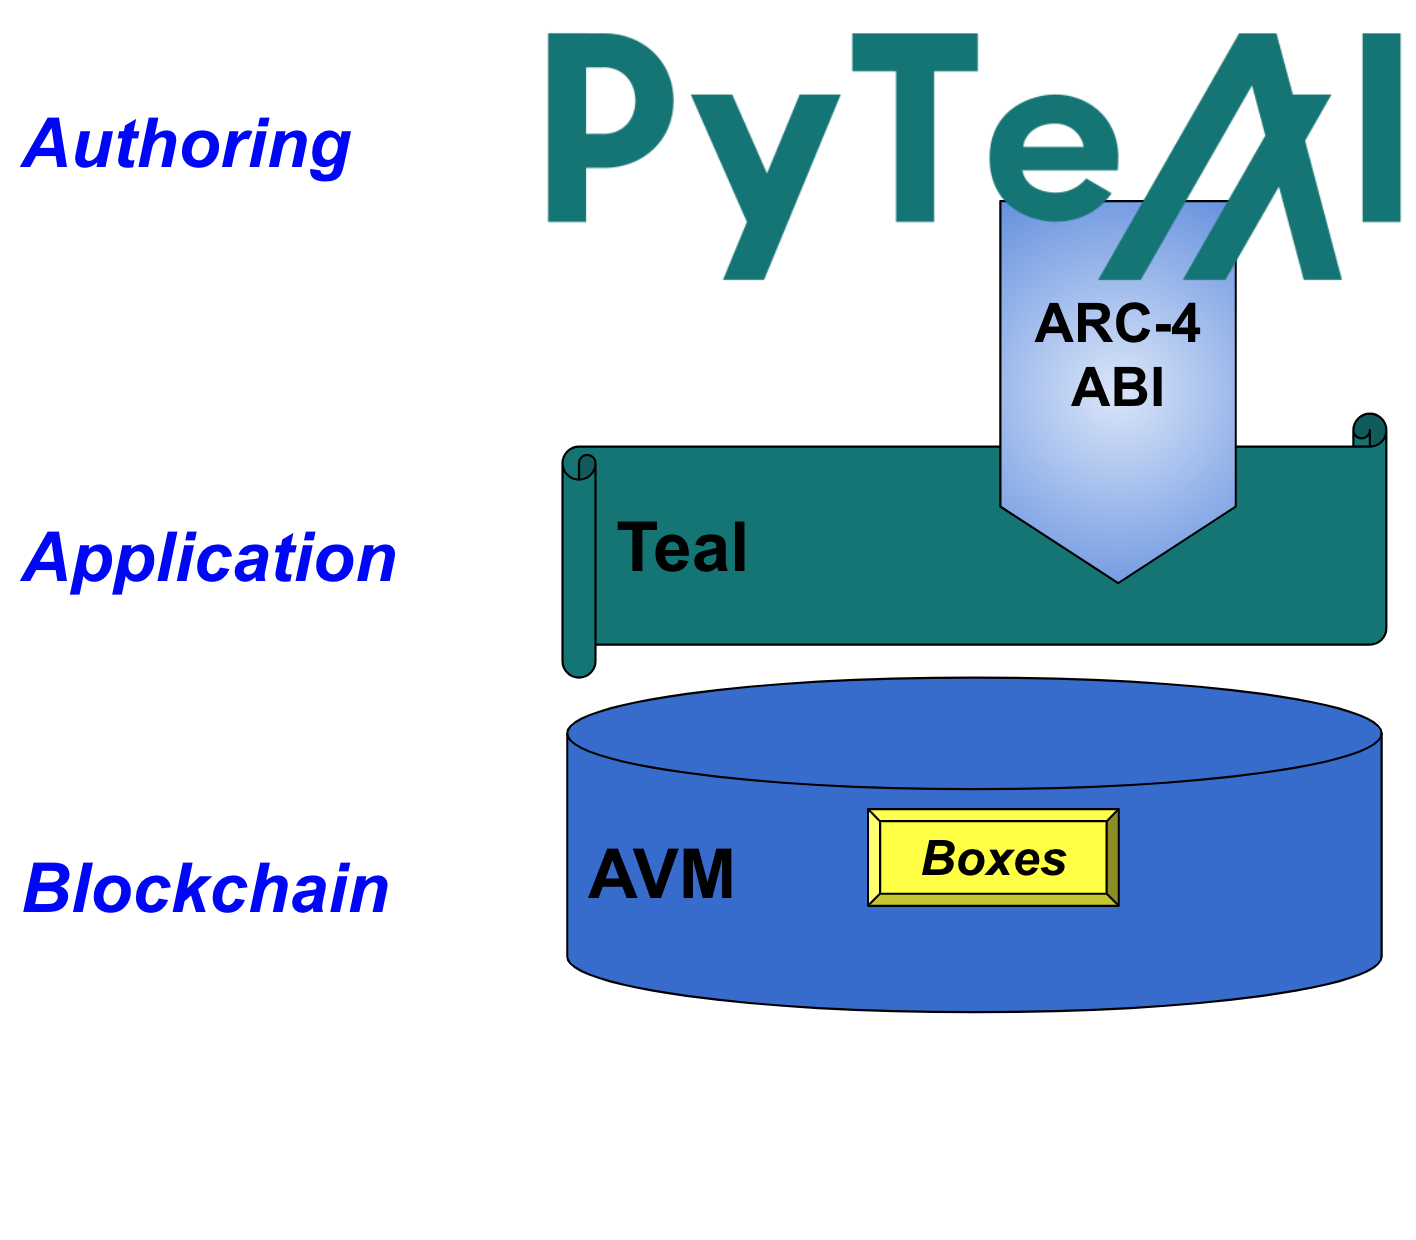

# <center>Polling App</center>

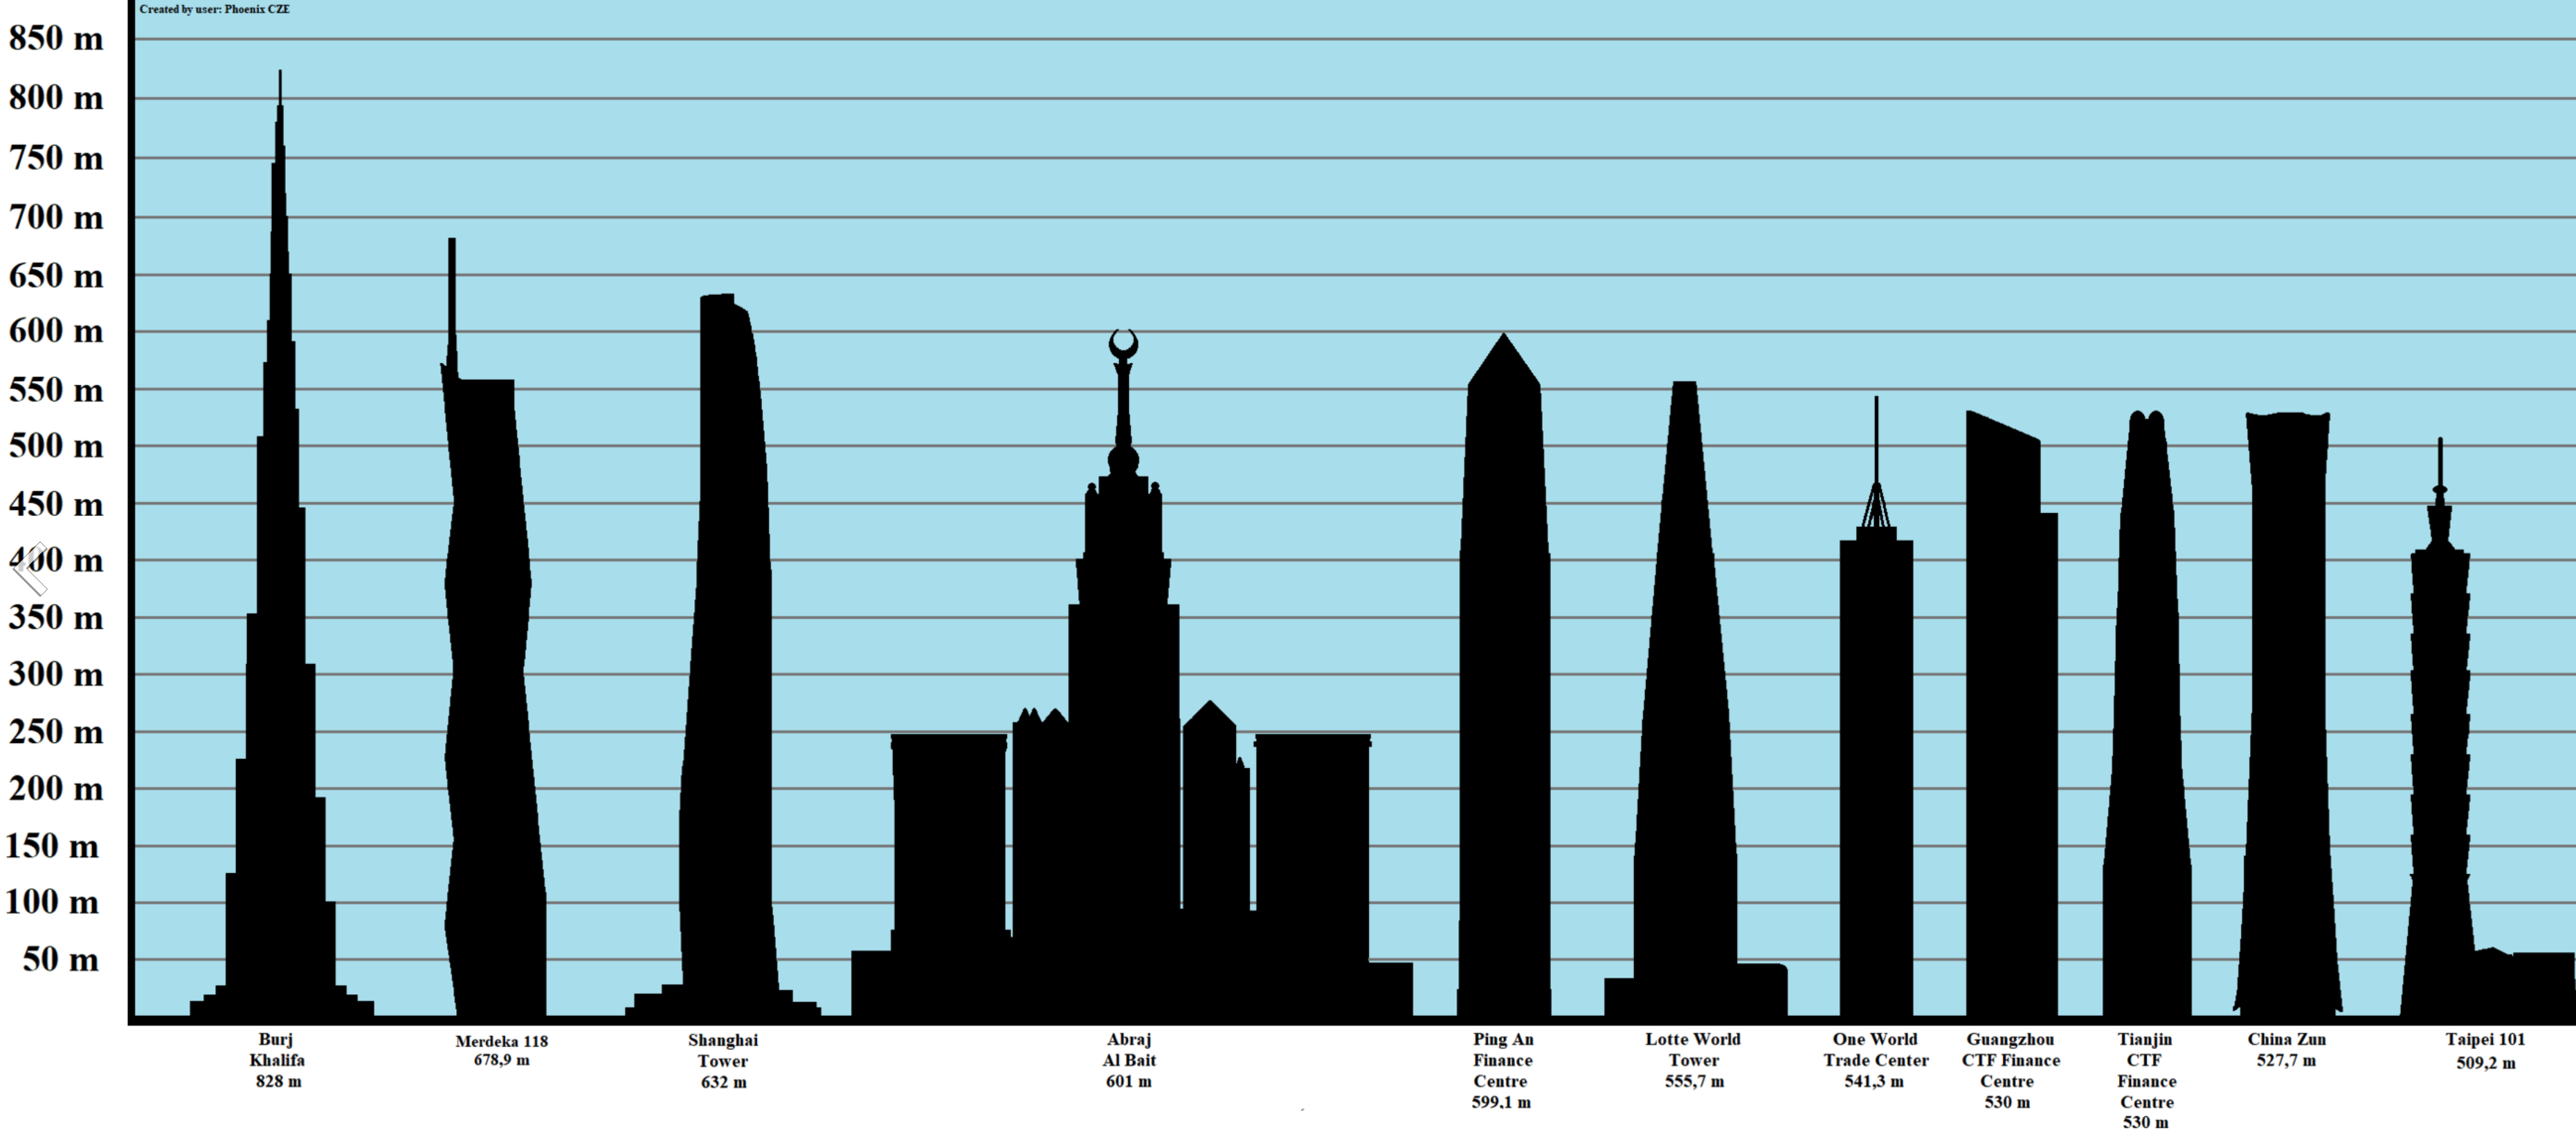

## Favorite Tall Building?

### 1. Empire State - New York
### 2. Burj Khalifa - Dubai
### 3. Abraj Al-Bait - Mecca
### 4. Taipei 101 - Taipei
### 5. Shanghai Tower - Shanghai
### 6. Merdeka 118 - Kuala Lumpur
### 7. Other



<h1 style='color:white'>.</h1>

# Let's Take a Poll On Chain



<h1 style='color:white'>.</h1>

### Poll **administrator** can:

### `create` and `delete` the poll application
### `open` and `close` a poll for voting

### **Anyone** can:

### `submit` a choice  
### get the poll `status`



<h1 style='color:white'>.</h1>

## Example

### `submit` choice **Burj Khalifa - Dubai**

### After 100 submissions
### `status` =
* **11** chose **Empire State - New York**
* **35** chose **Burj Khalifa - Dubai**
* **22** chose **Abraj Al-Bait - Mecca**
* ...



<h1 style='color:white'>.</h1>

## Problem: We don't want any account to have more influence than other accounts

## **OK**: Toma 
### `submit` choice **Taipei 101 - Taipei**

### END-RESULT: ✅ `Taipei += 1` ✅



<h1 style='color:white'>.</h1>

## **OK**: Sally
### a. `submit` choice **Taipei 101 - Taipei**
### b. change mind and re-`submit` choice **Shanghai Tower - Shanghai**

### END-RESULT: ✅ `Shanghai += 1` ✅



<h1 style='color:white'>.</h1>

## **_NOT_ OK**: Maryam
### a. `submit` choice for **Merdeka 118 - Kuala Lumpur**
### b. `submit` _ADDITIONAL_ choice for **Merdeka 118**
### . . .
### z. `submit` _ADDITIONAL_ choice for **Merdeka 118**

### END-RESULT: ❌ `Merdeka += 26` ❌



<h1 style='color:white'>.</h1>

In [6]:
%%script false --no-raise-error 

# Dead End

%pip install networkx
%pip install matplotlib

import networkx as nx
import matplotlib.pyplot as poll
import random
from networkx.algorithms import bipartite
CHOICES = 7
LAST = 10

choices = list(range(CHOICES))
accounts = [f"{' '*10}ACC {chr(x)}" for x in range(ord('A'), ord('A') + LAST)]

B = nx.Graph()
B.add_nodes_from(choices, bipartite=0)
B.add_nodes_from(accounts, bipartite=1)

# print(choices, accounts)
B.add_edges_from([(random.randint(0, CHOICES-1), acc) for acc in accounts])
pos = dict()
pos.update( (n, (1, LAST - i)) for i, n in enumerate(choices) ) 
pos.update( (n, (2, LAST - i)) for i, n in enumerate(accounts) ) 

# print(pos)
nx.draw_networkx(B, pos=pos, node_size=200)
nx.draw_networkx_nodes(B, pos=pos, nodelist=choices, node_size=300)
poll.axis('off')
poll.show()

## ENFORCE: accounts contribute $\leq$ 1 choice

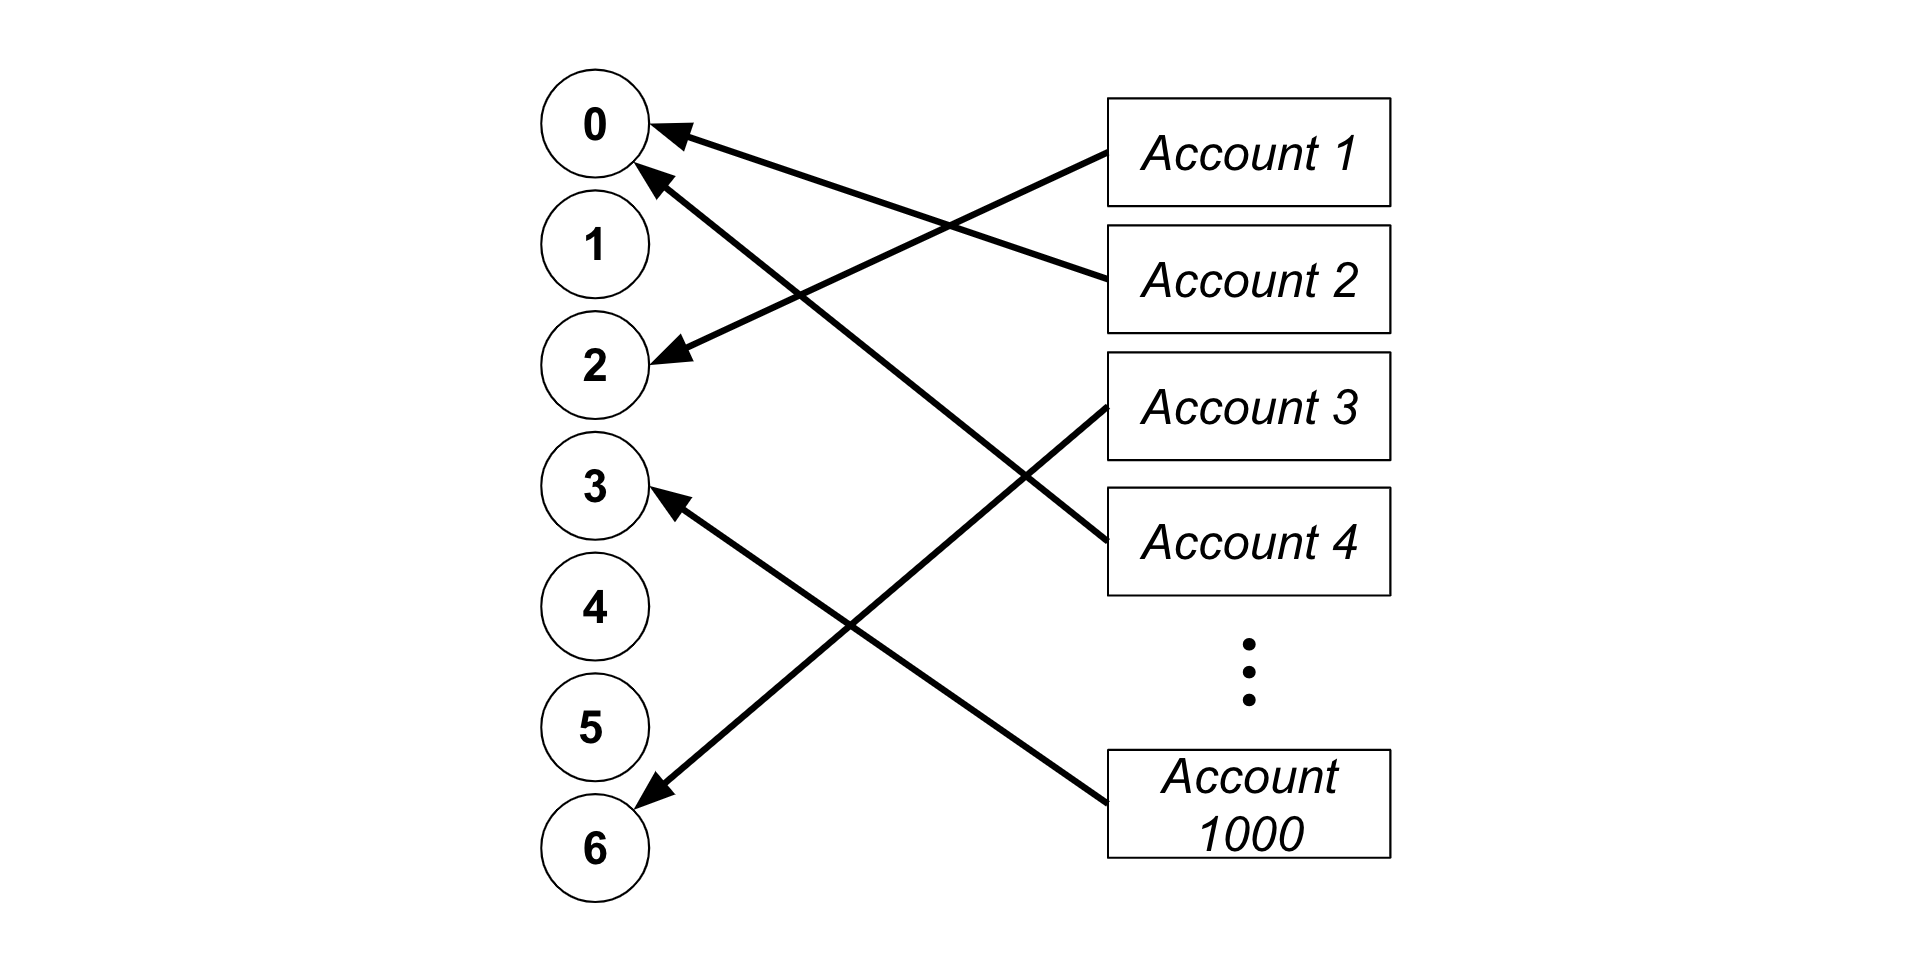



<h1 style='color:white'>.</h1>

NOTES:

* Can't keep all this info in global storage
    * Stats - 8KB total possible. Assuming no compression and 32B per address, 
        that's at most 256 accounts we can keep track of
* Can keep info in local - but then there are some downsides:
    * voters need to opt into poll (MBR issues)
    * need to have policies and code around closing/clearing out
* _TRICKY_ Sybil attack. Why can't some create tons of accounts and vote many times.
    AND it's even easier to pull that off with the reduced MBR requirements
    thanks to boxes...
    * Answer: yes, this isn't meant to be a solution to the general problem of
        governance voting, etc.
    * This is only meant for low-stake polls

## Each account only contributes to $\leq$ 1 choice

# <center>**HOW ?**</center>

## Can we store each account in **global storage**?

https://github.com/algorand/go-algorand/blob/995ae47e80c50e7632034cac8a70b7d6434d03e3/config/consensus.go#L969-L970

`64 keys X (64 + 64 bytes) == 8,196 bytes`

### Yes, BUT _limited to 8KB_ which is only **_256 accounts_** (if not compressing)



<h1 style='color:white'>.</h1>

# <center>**HOW ?**</center>

## Can we keep track of an account's vote in **local storage**?

### Yes, BUT requires `opt in`
### `clear state` forcibly erases submission record

#### min `MBR = 0.15 Algos` with 1 local
#### complex code/policies for `opt in`, `close out`, `clear state`



<h1 style='color:white'>.</h1>

### Anything else we could do?

### **UNLIMITED assets**
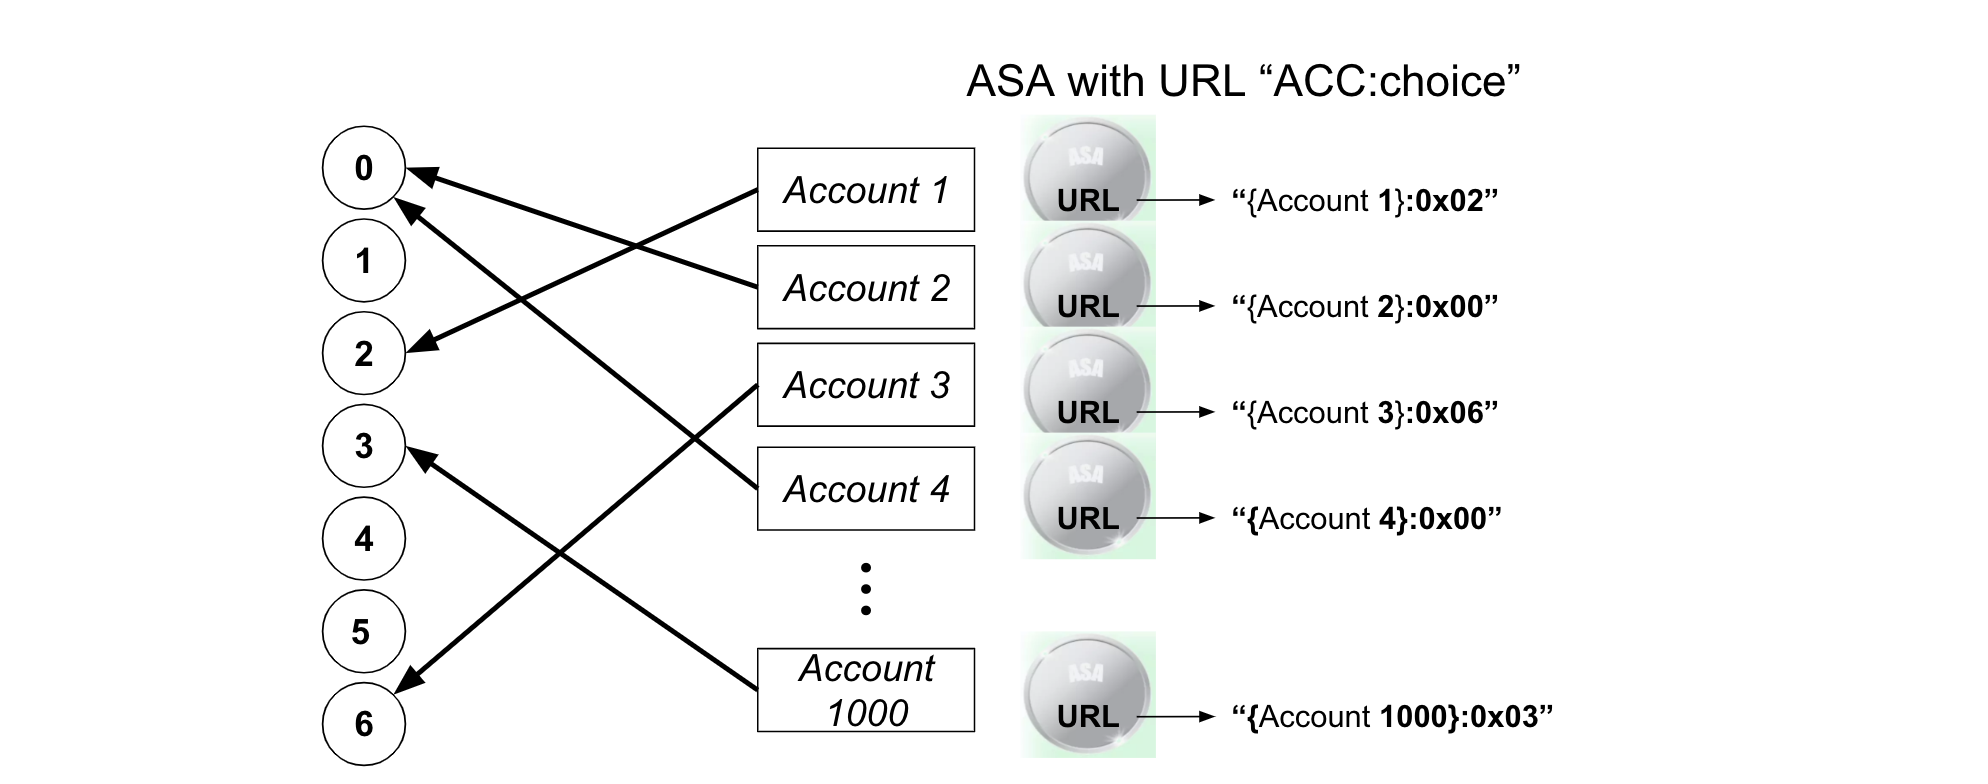

### _hack_ a new asset for each account that submits
#### **_complicated_**,  **_error prone_**, **_expensive_**

Notes:
* **expensive** 0.1 Algos / acct vs. 0.0157 Algos / acct w/ boxes
* **complicated / error prone**
    * need to keep track of asset id off chain and supply it as a foreign ref, then parse out URL, verify that first 32 bytes are the account, etc...
    * need to group with `Asset Config Txn` which specifies how the URL changes



<h1 style='color:white'>.</h1>

## <center> SOLUTION </center>

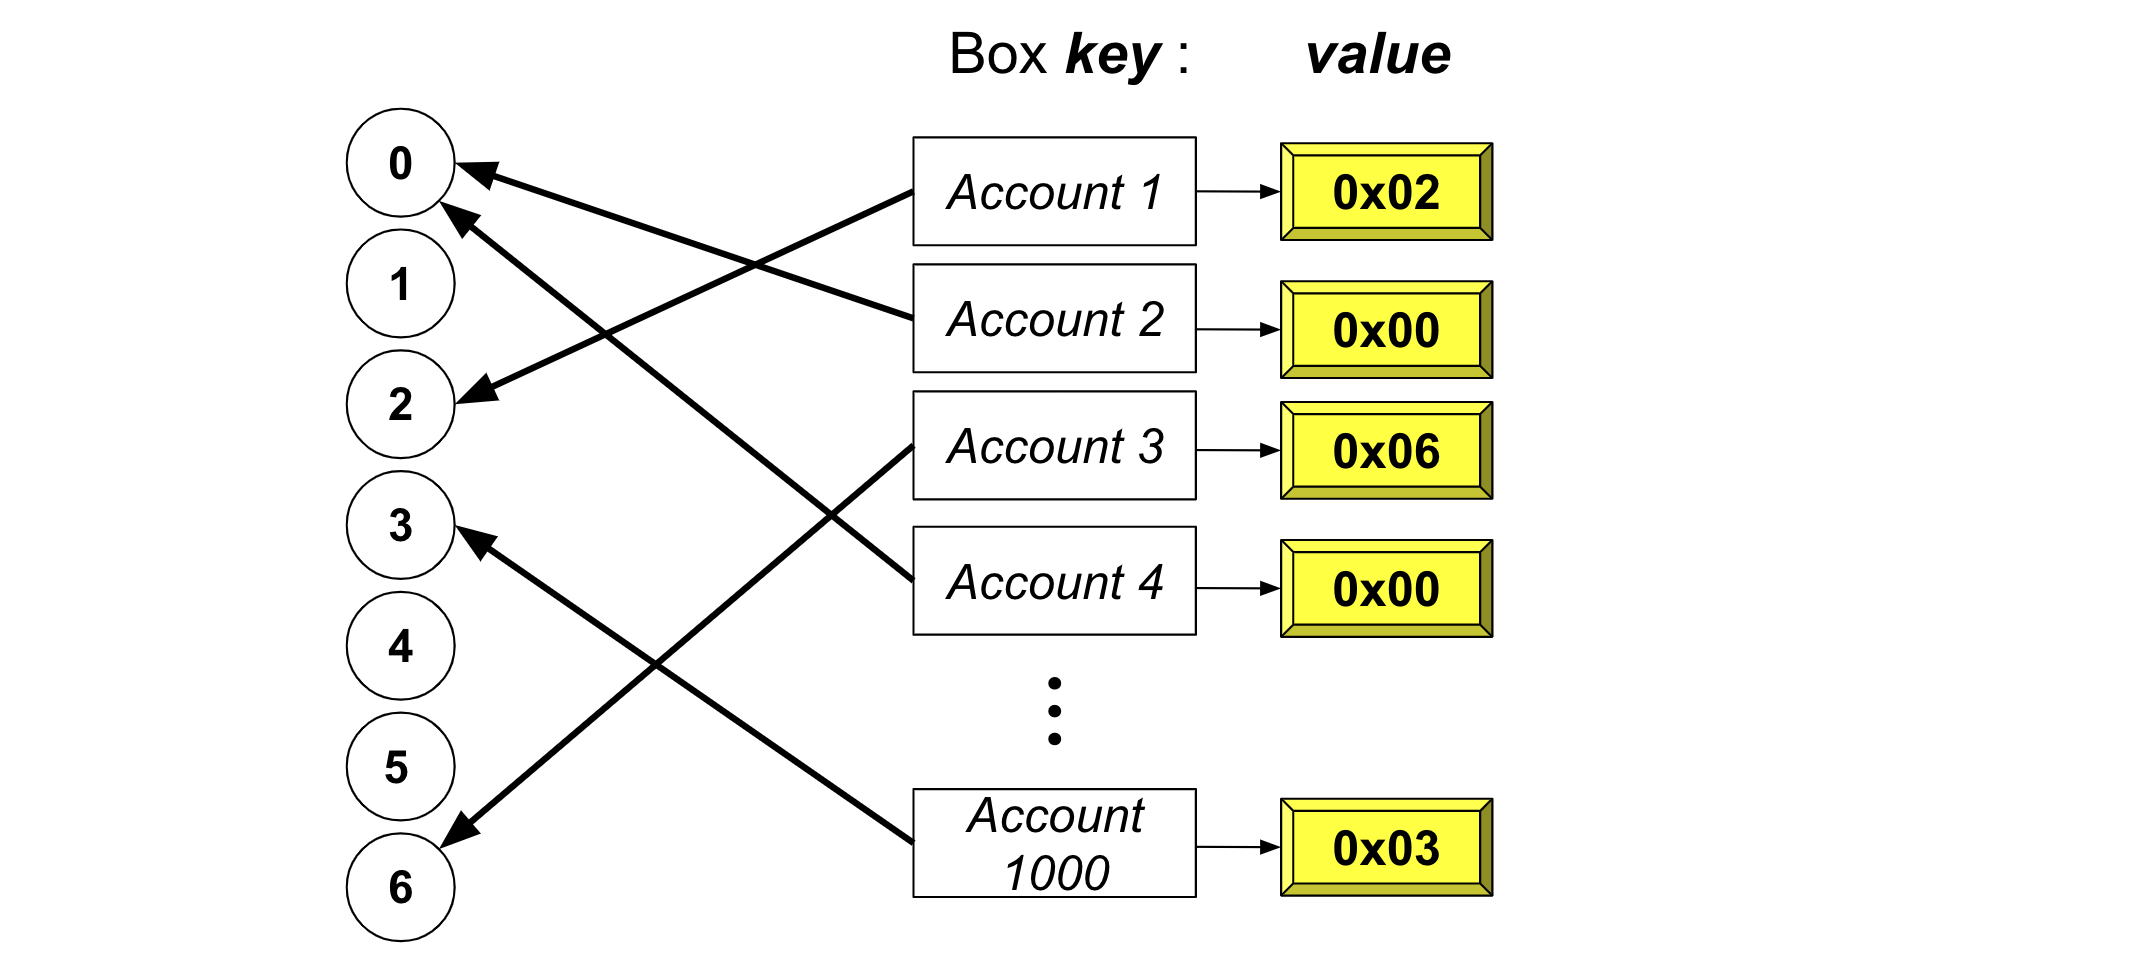

Notes:
* In this solution, only need
    * 32 bytes for the Key (max is 64 bytes)
    * 1 byte for the value (max is 32 **KB**)
* Costs in terms of MBR formula of 2500 + 400*(len(key) + len(value))
    * 15.7 mili-Algo's to store submission info per account
    * Each txn allows up to 8 box references in it with the size of boxes touched totalling at most 1KB * # of refs
    * In our case, this is not an issue. A single box reference -being the submission account- will suffice



<h1 style='color:white'>.</h1>

# <center>Application Boxes in PyTeal</center>



<h1 style='color:white'>.</h1>

### `App.box_get()` and `App.box_put()`

Notes

Inspired by
```python
@router.method
def submit(choice: abi.Uint8) -> Expr:
```

* `sender_box` is a `MaybeValue`:
    * `sender_box.has_value() <--> box exists`
    * `sender_box.value() --> (when box exists) full contents`

In [7]:
num_choices = Int(7)
choice = Bytes(b"\x01") # "Burj Khalifa - Dubai"'s index as bytes
sender_box = App.box_get(Txn.sender())

key_prefix = Bytes(b"option_count_")
choice_key = Concat(key_prefix, choice)
old_key = ScratchVar(TealType.bytes)
submit_expr = Seq(
    Assert(Btoi(choice) < num_choices),
    If(sender_box.hasValue()).Then(
        # clear sender's previous response
        old_key.store(Concat(key_prefix, sender_box.value())),
        App.globalPut(
            old_key.load(),
            App.globalGet(old_key.load()) - Int(1),
        ),
    ),
    App.box_put(Txn.sender(), choice),
    App.globalPut(choice_key, App.globalGet(choice_key) + Int(1)),
)



<h1 style='color:white'>.</h1>

Notes:
* `box_len` returns multi-value that also let's you know if the box exists in addition to the length

### <center>PyTeal `App.box_*()` API</center>

### `App.box_create(name, size)` -  _any_ size ($\leq$ 32KB)
### `App.box_length(name)` - _opcode `box_len`_ 
### `App.box_delete(name)` - _opcode `box_del`_
### `App.box_replace(name, idx, L)` - set part of box
### `App.box_extract(name, idx, L)` - get part of box
### `App.box_put(name, value)` - set contents (may create)
### `App.box_get(name)` - get everything (fail if size > 4KB)



<h1 style='color:white'>.</h1>

### Boxes vs. Other Storage Mechanisms

<div style="width:750px">
    
|  <div style="width:180px">Property</div> | <div style="width:150px">Global Storage</div> | <div style="width:150px">Local Storage</div> | <div style="width:150px">Box Storage</div> |
|:--- |:--- |:--- |:--- |
| **Max**(&#124;key&#124; + &#124;value&#124;) | 128 bytes | 128 bytes | 32,832 bytes |
| Max storage | 64 pairs or 8 KB | 16 pairs or 2 KB | $\infty$ |
| On-Chain Visibility | Public | Public | Private: boxes only visible to their app |
| Best Case MBR<sup>*</sup> | 0.40 Algo/KB | 0.40 Algo/KB | 0.41 Algo/KB |
| Account for MBR | Creator Account | Opt-In Account | App Account |
| When App is Deleted | Automatically erased | _same as Global_ | **Forever lost on chain**<sup>**</sup> |
| External Ref in Txn | None | None | Box reference required |

</div>

### <sup>*</sup> Approximation with optimized usage
### <sup>**</sup> Best practice requires making app deletion contingent on prior box cleanup



<h1 style='color:white'>.</h1>

# PyTeal's ABI-Router: _Building an ARC-4 Application_



<h1 style='color:white'>.</h1>

### `methods` - allow interacting with **Poll App**

### * `create` - called only _during app creation_ and only _by administrator_
### * `open` - called only _by administrator_
### * `close` - called only _by administrator_
### * `submit`
### * `status`

### _(didn't include `delete` for reasons to be explained shortly)_



<h1 style='color:white'>.</h1>

### **Refresher** - `OnComplete` **Actions** for App Transactions

<table>
<thead>
<tr>
<th>Value</th>
<th>Name</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>NoOp</td>
<td>Execute <code>ApprovalProgram</code> only</td>
</tr>
<tr>
<td>1</td>
<td>OptIn</td>
<td>Allocate local state and execute <code>ApprovalProgram</code></td>
</tr>
<tr>
<td>2</td>
<td>CloseOut</td>
<td>Execute <code>ApprovalProgram</code> and clear local state</td>
</tr>
<tr>
<td>3</td>
<td>ClearState</td>
    <td>Execute <code>ClearStateProgram</code> and clear locals (even if <i>rejects</i>)</td>
</tr>
<tr>
<td>4</td>
<td>UpdateApplication</td>
<td>Execute <code>ApprovalProgram</code> and update programs</td>
</tr>
<tr>
<td>5</td>
<td>DeleteApplication</td>
<td>Execute <code>ApprovalProgram</code> and delete the app</td>
</tr>
</tbody>
</table>



<h1 style='color:white'>.</h1>

### **Definition**: `method`

### An _ABI_ `method` is a section of code called externally through an application transaction whose first argument is the method's `selector`

### **Definition**: `Bare app call action`

### An _ABI_ `bare app call` is an application transaction with zero arguments and its associated `action` is the section of code to be executed



<h1 style='color:white'>.</h1>

### **Definition**: the `Router` and its **_M.O.E._** Questions

<center><figure>
  <img src="images/moe.png" alt="Moe of the 3 Stooges" width="400">
</figure></center>

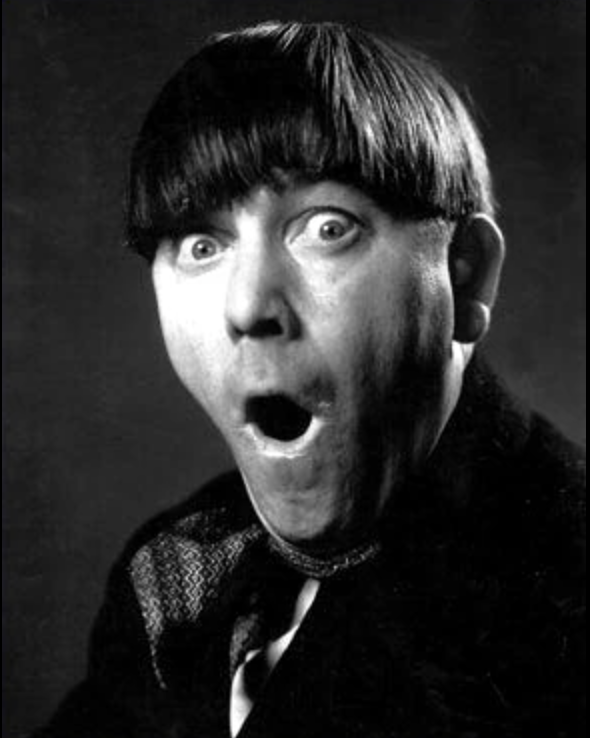

In [8]:
moe()



<h1 style='color:white'>.</h1>

### **Definition**: a `Router` and its **_M.O.E._** Questions

### PyTeal's `Router` constructs the Teal code necessary to delegate _application transactions_ to either a `bare app call action` or a `method` based on answers to:

### _[**M**]_  In a `bare app call`? If not, which `method` selected?
### _[**O**]_  Which `OnComplete` is requested?
### _[**E**]_  This app already `exists`? (Conversely, being `created`?)



<h1 style='color:white'>.</h1>

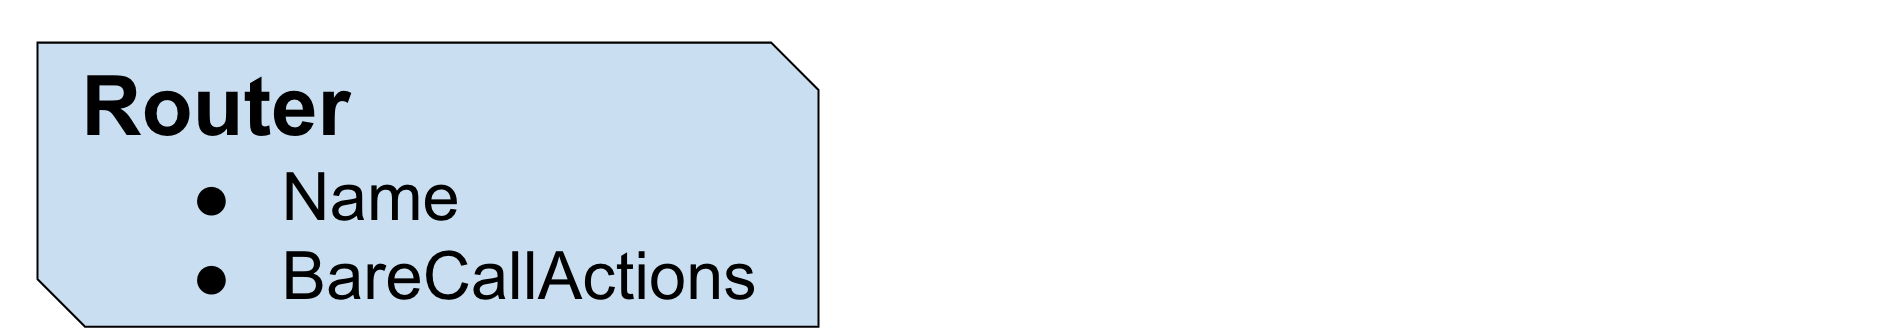



<h1 style='color:white'>.</h1>

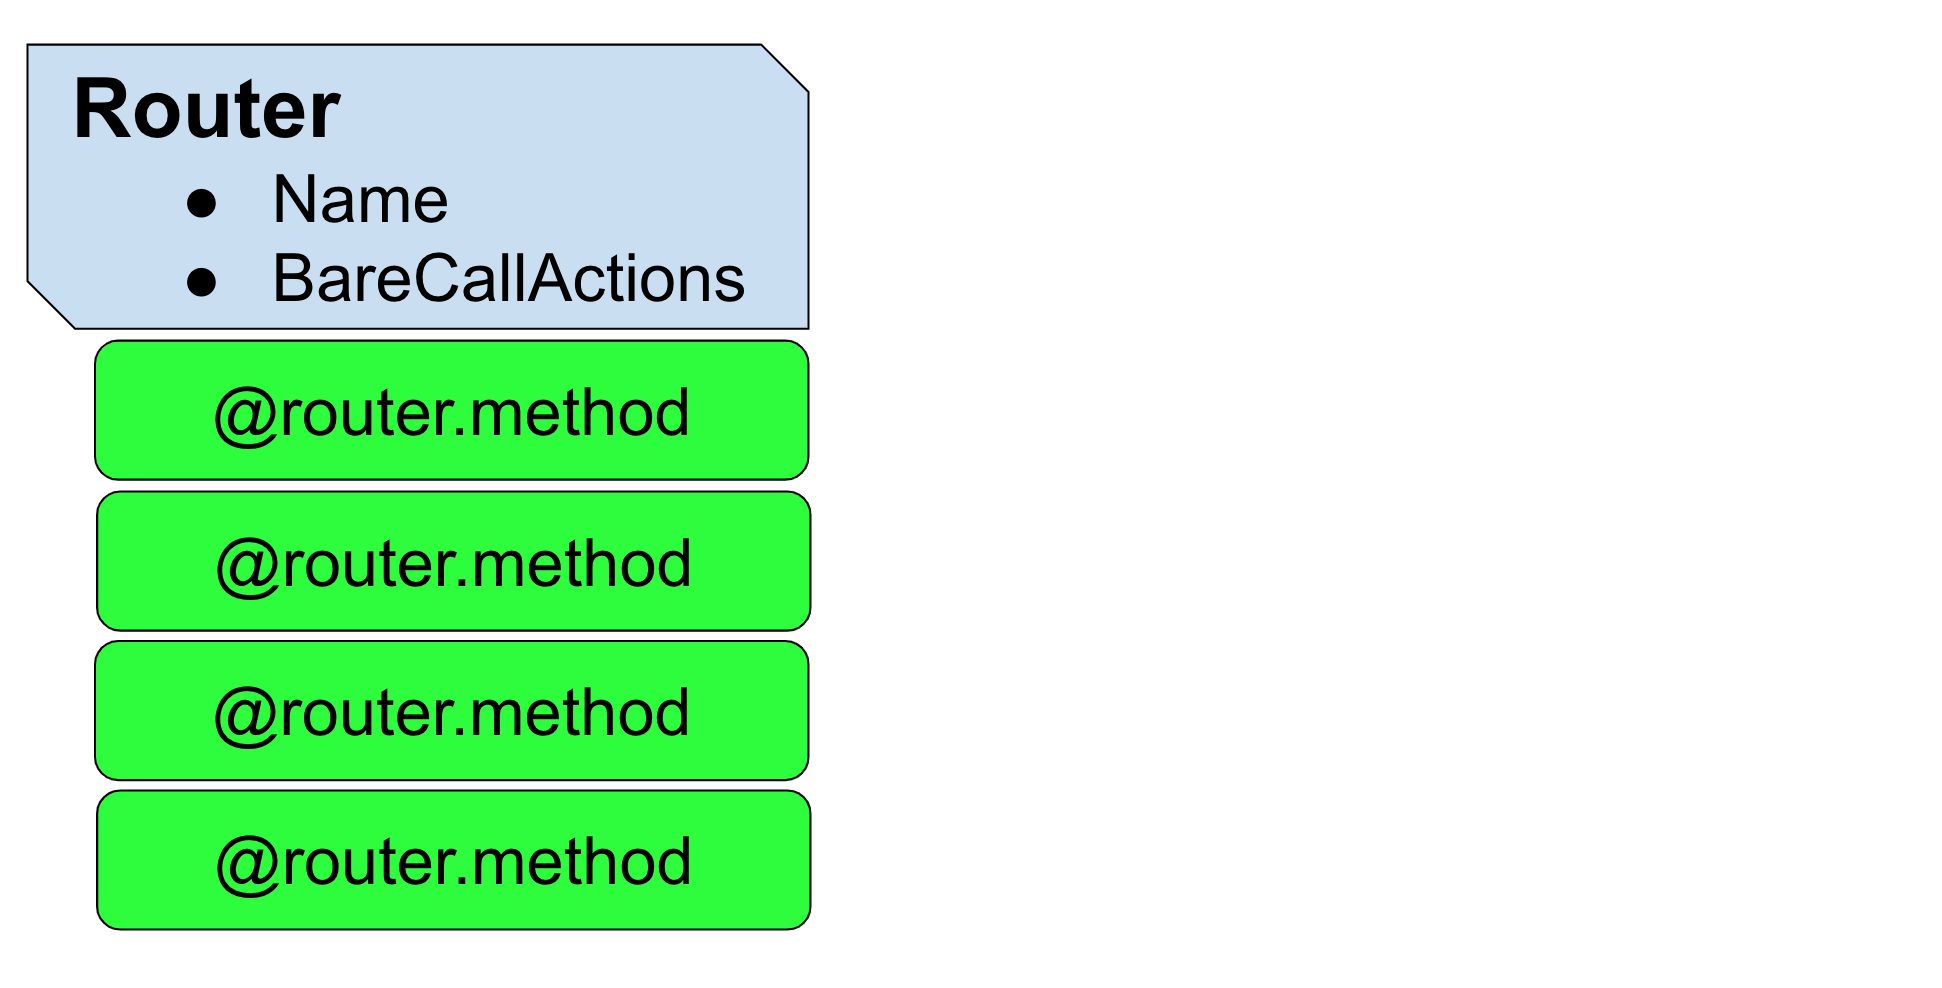



<h1 style='color:white'>.</h1>

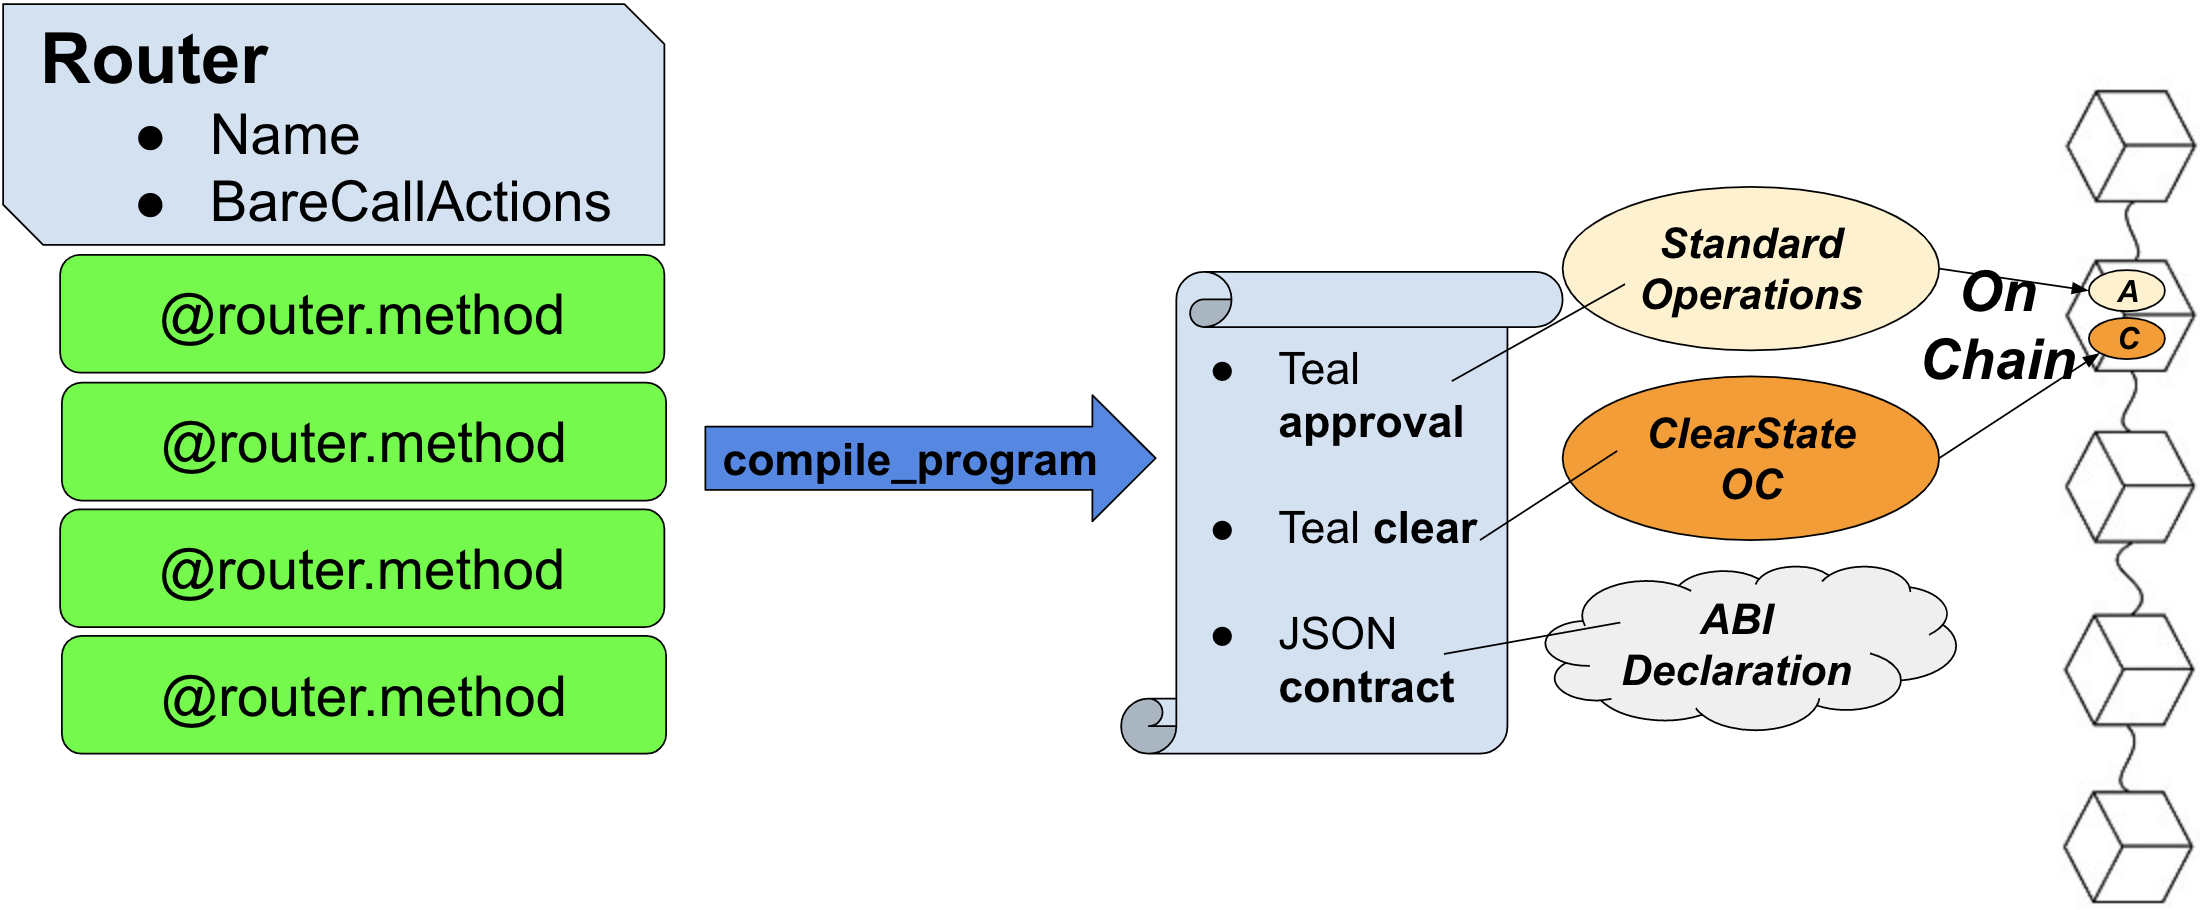



<h1 style='color:white'>.</h1>

### `Router` Initialization

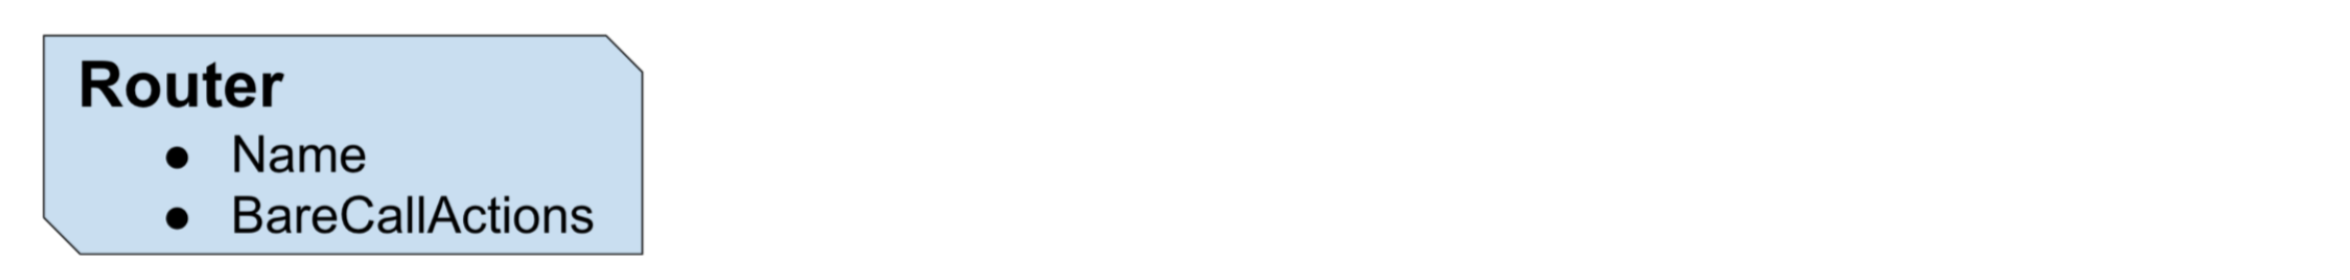



<h1 style='color:white'>.</h1>

<center><figure>
  <img src="images/warning.jpeg" alt="Warning" width="200">
</figure></center>

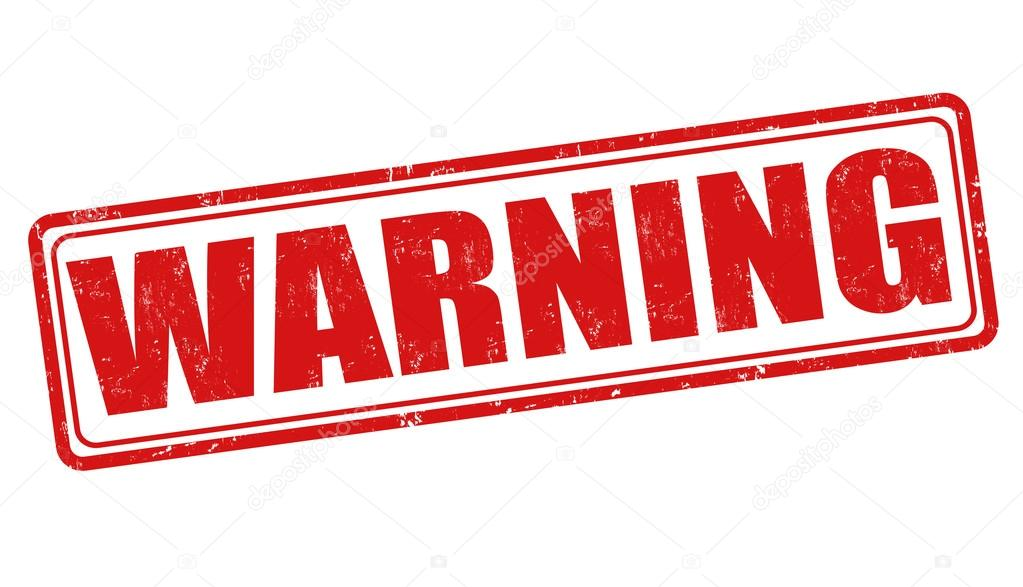

In [9]:
warning()

In [10]:
# WARNING: STUBS ARE FOR ROUTER-ILLUSTRATION PURPOSES ONLY!!!

del_action = OnCompleteAction.call_only(Seq()) 

router = Router(
    name="OpenPollingApp",
    descr="This is a polling application.",
    bare_calls=BareCallActions(delete_application=del_action),
)



<h1 style='color:white'>.</h1>

In [11]:
approval, clear, json_contract = router.compile_program(version=8)

### Compile

```python
approval, clear, json_contract = router.compile_program(version=8)
```

### `JSON` Contract (with no methods)

In [12]:
print(json.dumps(json_contract.dictify(), indent=2))

{
  "name": "OpenPollingApp",
  "methods": [],
  "networks": {},
  "desc": "This is a polling application."
}




<h1 style='color:white'>.</h1>

### Compile

```python
approval, clear, json_contract = router.compile_program(version=8)
```

In [13]:
print(approval)

#pragma version 8
txn NumAppArgs
int 0
==
bnz main_l2
err
main_l2:
txn OnCompletion
int DeleteApplication
==
bnz main_l4
err
main_l4:
txn ApplicationID
int 0
!=
assert
int 1
return




<h1 style='color:white'>.</h1>

In [14]:
%%script false --no-raise-error #pragma version 8
txn NumAppArgs
int 0
==
bnz main_l2
err
main_l2:
txn OnCompletion
int DeleteApplication
==
bnz main_l4
err
main_l4:
txn ApplicationID
int 0
!=
assert
int 1
return

### **Routing** _bare app call_ `delete`

In [15]:
show.prepare(approval, (2, 5), (7, 11), (13, 19))

In [16]:
show() # custom method showing relevant Teal

```
txn NumAppArgs
int 0
==
bnz main_l2
. . .
main_l2:
txn OnCompletion
int DeleteApplication
==
bnz main_l4
. . .
main_l4:
txn ApplicationID
int 0
!=
assert
int 1
return
```



<h1 style='color:white'>.</h1>

### Append `methods` to route with `@router.method`

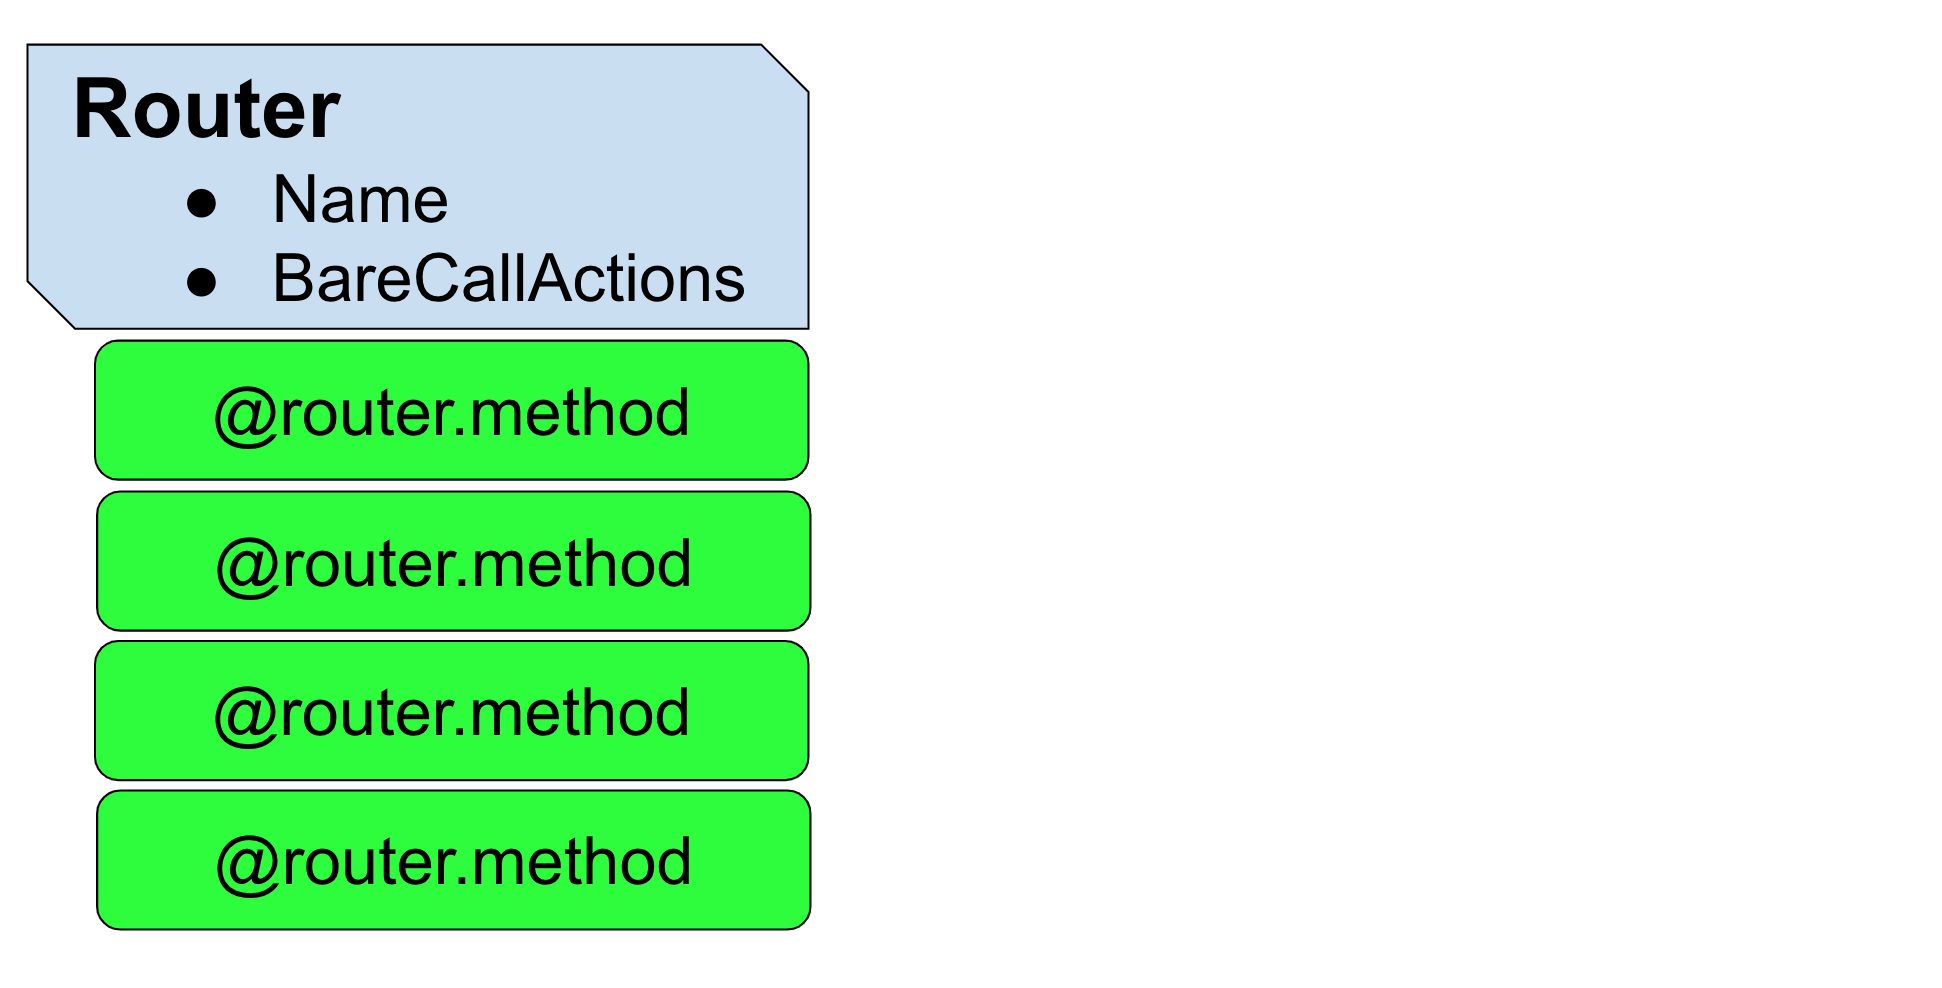



<h1 style='color:white'>.</h1>

### Route `open()` and `close()`

### * no args or output
### * `OnComplete == NoOp` and not during _create_

Note:

PyTeal lets us name each method with a the Python reserved word 
(`open` and `close`) via the `name` param

In [17]:
@router.method(name="open")
def open_poll() -> Expr:
    """Marks this poll as open."""
    return Seq()

@router.method(name="close")
def close_poll() -> Expr:
    """Marks this poll as closed."""
    return Seq()

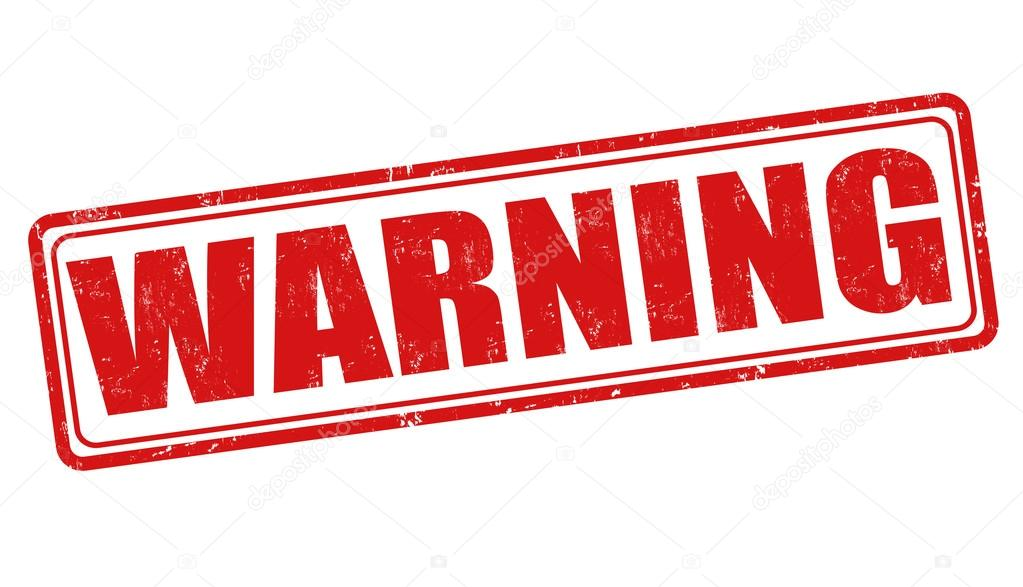

In [18]:
warning()

<center><figure>
  <img src="images/warning.jpeg" alt="Warning" width="300">
</figure></center>



<h1 style='color:white'>.</h1>

## Compile

In [19]:
approval, clear, json_contract = router.compile_program(version=8)

### `JSON` Contract Stub (with 2 simple method)

Now the methods do get filled with information.

In [20]:
print(json.dumps(json_contract.dictify(), indent=2))

{
  "name": "OpenPollingApp",
  "methods": [
    {
      "name": "open",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as open."
    },
    {
      "name": "close",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as closed."
    }
  ],
  "networks": {},
  "desc": "This is a polling application."
}


In [21]:
# print(approval)

In [22]:
%%script false --no-raise-error #pragma version 8
txn NumAppArgs
int 0
==
bnz main_l6
txna ApplicationArgs 0
method "open()void"
==
bnz main_l5
txna ApplicationArgs 0
method "close()void"
==
bnz main_l4
err
main_l4:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_1
int 1
return
main_l5:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_0
int 1
return
main_l6:
txn OnCompletion
int DeleteApplication
==
bnz main_l8
err
main_l8:
txn ApplicationID
int 0
!=
assert
int 1
return

// open
open_0:
retsub

// close
close_1:
retsub

### Approval Program - **Routing** to `open` and `close`

In [23]:
show.prepare(approval, (6, 9), (10, 13), (27, 36), (15, 24), (53, 55), (57, 59))

Notes:
* `method` pseudo-opcode computes the method selector (SHA512-256 of the method signature)
* router ask Q1 by comparing with `txna ApplicationArgs 0` (method args start at `txn ApplicationArgs 1`) and branches to relevant label
* then asks Q2 & Q3 by asserting thet `OnCompletion` == `NoOp` and already existing `ApplicatoinId != 0`
* then routes to actual subroutine that implements the method with a `callsub`

In [24]:
show()

```
txna ApplicationArgs 0
method "open()void"
==
bnz main_l5
. . .
txna ApplicationArgs 0
method "close()void"
==
bnz main_l4
. . .
main_l5:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_0
. . .
main_l4:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_1
. . .
// open
open_0:
retsub
. . .
// close
close_1:
retsub
```

# ABI Types



<h1 style='color:white'>.</h1>

### A Selection of PyTeal's Basic ABI Types

<table class="docutils align-default">
<colgroup>
<col style="width: 18%">
<col style="width: 9%">
<col style="width: 14%">
<col style="width: 59%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>PyTeal Type</p></th>
<th class="head"><p>ARC-4 Type</p></th>
<th class="head"><p>Dynamic / Static</p></th>
<th class="head"><p>Description</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><a class="reference internal" href="https://pyteal.readthedocs.io/en/stable/api.html#pyteal.abi.Uint8" title="pyteal.abi.Uint8"><code class="xref any py py-class docutils literal notranslate"><span class="pre">abi.Uint8</span></code></a></p></td>
<td><p><code class="code docutils literal notranslate"><span class="pre">uint8</span></code></p></td>
<td><p>Static</p></td>
<td><p>An 8-bit unsigned integer</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="https://pyteal.readthedocs.io/en/stable/api.html#pyteal.abi.StaticArray" title="pyteal.abi.StaticArray"><code class="xref any py py-class docutils literal notranslate"><span class="pre">abi.StaticArray[T,N]</span></code></a></p></td>
<td><p><code class="code docutils literal notranslate"><span class="pre">T[N]</span></code></p></td>
    <td><p><b>IFF</b> <code class="code docutils literal notranslate"><span class="pre">T</span></code> is</p></td>
<td><p>A fixed-length array with <span class="pre">N</span></code> elements</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="https://pyteal.readthedocs.io/en/stable/api.html#pyteal.abi.String" title="pyteal.abi.String"><code class="xref any py py-class docutils literal notranslate"><span class="pre">abi.String</span></code></a></p></td>
<td><p><code class="code docutils literal notranslate"><span class="pre">string</span></code></p></td>
<td><p>Dynamic</p></td>
<td><p>Variable-length byte array</p></td>
</tr>
</tbody>
</table>

## There are more!

### Uint16/32/64, Bool, Byte, DynamicArray, Tuple, ...

### <center>Link: <a href="https://pyteal.readthedocs.io/en/stable/abi.html#definitions">PyTeal ABI Types</a></center>



<h1 style='color:white'>.</h1>

### Add a **method** with _ABI arguments_

Notes
* utilizes `choice: abi.Uint8`
* take a mental note of the _Docstring_ """Submit ... """
    * The very first line becomes the `desc` field of the method in the JSON contract

In [25]:
@router.method
def submit(choice: abi.Uint8) -> Expr:
    """Submit a response to the poll.
    Args:
        choice: The choice made by the sender.
    """
    return Seq()

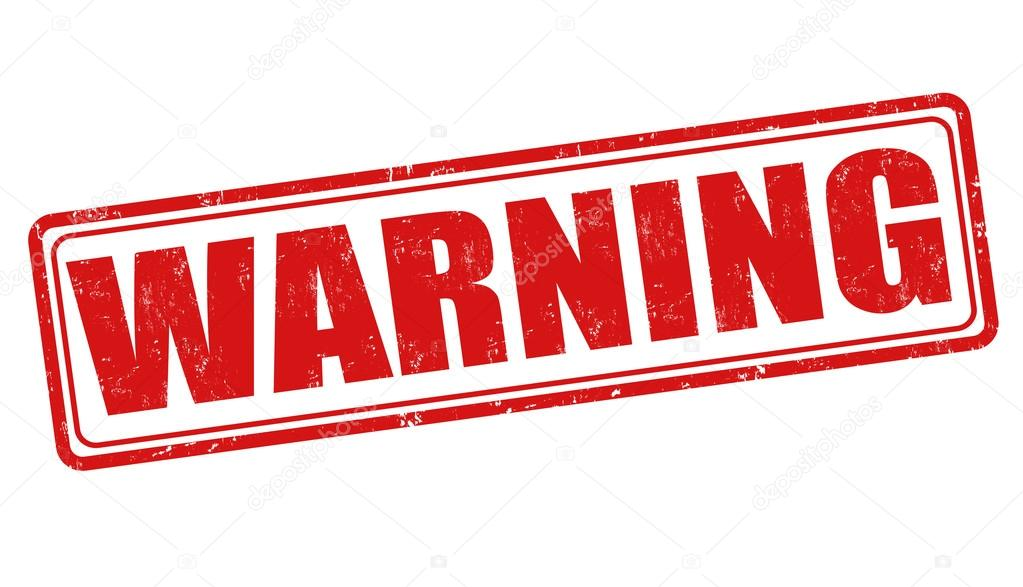

In [26]:
warning()

<center><figure>
  <img src="images/warning.jpeg" alt="Warning" width="300">
</figure></center>



<h1 style='color:white'>.</h1>

#### Compile

In [27]:
opts = OptimizeOptions(scratch_slots=True)
(approval, clear, json_contract) = \
    router.compile_program(version=8, optimize=opts)
# ------------------------------------^^^^^^^^^^^^^

In [28]:
print(json.dumps(json_contract.dictify(), indent=2))

{
  "name": "OpenPollingApp",
  "methods": [
    {
      "name": "open",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as open."
    },
    {
      "name": "close",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as closed."
    },
    {
      "name": "submit",
      "args": [
        {
          "type": "uint8",
          "name": "choice",
          "desc": "The choice made by the sender."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Submit a response to the poll."
    }
  ],
  "networks": {},
  "desc": "This is a polling application."
}


In [29]:
%%script false --no-raise-error #{
  "name": "OpenPollingApp",
  "methods": [
    {
      "name": "open",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as open."
    },
    {
      "name": "close",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as closed."
    },
    {
      "name": "submit",
      "args": [
        {
          "type": "uint8",
          "name": "choice",
          "desc": "The choice made by the sender."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Submit a response to the poll."
    }
  ],
  "networks": {},
  "desc": "This is a polling application."
}

### `submit(choice)` portion of `JSON` contract

Notes:
* `desc` is coming from the defining Python function's _Docstring_

In [30]:
show.prepare(json.dumps(json_contract.dictify(), indent=2), (20, 33))

In [31]:
show() # lines 20-33 of the JSON contract

```
    {
      "name": "submit",
      "args": [
        {
          "type": "uint8",
          "name": "choice",
          "desc": "The choice made by the sender."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Submit a response to the poll."
    }
```



<h1 style='color:white'>.</h1>

In [32]:
# print(approval)

In [33]:
%%script false --no-raise-error #pragma version 8
txn NumAppArgs
int 0
==
bnz main_l8
txna ApplicationArgs 0
method "open()void"
==
bnz main_l7
txna ApplicationArgs 0
method "close()void"
==
bnz main_l6
txna ApplicationArgs 0
method "submit(uint8)void"
==
bnz main_l5
err
main_l5:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
txna ApplicationArgs 1
int 0
getbyte
callsub submit_2
int 1
return
main_l6:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_1
int 1
return
main_l7:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_0
int 1
return
main_l8:
txn OnCompletion
int DeleteApplication
==
bnz main_l10
err
main_l10:
txn ApplicationID
int 0
!=
assert
int 1
return

// open
open_0:
retsub

// close
close_1:
retsub

// submit
submit_2:
store 0
retsub

In [34]:
show.prepare(approval, (14, 17), (19, 31), (80, 83))

### Routing `submit(choice)`

In [35]:
show()

```
txna ApplicationArgs 0
method "submit(uint8)void"
==
bnz main_l5
. . .
main_l5:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
txna ApplicationArgs 1
int 0
getbyte
callsub submit_2
. . .
// submit
submit_2:
store 0
retsub
```

**OMIT THE REST OF THE STUBS FROM PRESENTATION**

### Add **method** `create()` for during _create_

Notes:
* `@router.method` decorator is signalled about looking for an `OnComplete==NoOp` during an app `create` 
* introducing types `abi.StaticArray[abi.String, Literal[3]]`, `abi.Bool`
* the first is recursively "dynamic type" 
    * **dynamic** means that the _size_ of data being encoded is not fixed
* ARC-4 specifies exactly how each type is encoded

In [36]:
@router.method(no_op=CallConfig.CREATE)
def create(
    options: abi.StaticArray[abi.String, Literal[3]], 
    can_resubmit: abi.Bool,
) -> Expr:
    """Create a new polling application.

    Args:
        options: A list of options for the poll.
    """
    return Seq()



<h1 style='color:white'>.</h1>

#### Compile

In [37]:
approval, clear, json_contract = router.compile_program(version=8, optimize=opts)

#### Approval Program Stub (with 2 simple methods + 1 non-returning `OnComplete=NoOp` + 1 non-returning during creation)

In [38]:
# print(approval)

In [39]:
%%script false --no-raise-error #pragma version 8
txn NumAppArgs
int 0
==
bnz main_l10
txna ApplicationArgs 0
method "open()void"
==
bnz main_l9
txna ApplicationArgs 0
method "close()void"
==
bnz main_l8
txna ApplicationArgs 0
method "submit(uint8)void"
==
bnz main_l7
txna ApplicationArgs 0
method "create(string[3],bool)void"
==
bnz main_l6
err
main_l6:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
==
&&
assert
txna ApplicationArgs 1
store 1
txna ApplicationArgs 2
int 0
int 8
*
getbit
store 2
load 1
load 2
callsub create_3
int 1
return
main_l7:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
txna ApplicationArgs 1
int 0
getbyte
callsub submit_2
int 1
return
main_l8:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_1
int 1
return
main_l9:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_0
int 1
return
main_l10:
txn OnCompletion
int DeleteApplication
==
bnz main_l12
err
main_l12:
txn ApplicationID
int 0
!=
assert
int 1
return

// open
open_0:
retsub

// close
close_1:
retsub

// submit
submit_2:
store 0
retsub

// create
create_3:
store 4
store 3
retsub

In [40]:
show.prepare(approval, (18,21), (23, 42), (111, 115))

In [41]:
show()

```
txna ApplicationArgs 0
method "create(string[3],bool)void"
==
bnz main_l6
. . .
main_l6:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
==
&&
assert
txna ApplicationArgs 1
store 1
txna ApplicationArgs 2
int 0
int 8
*
getbit
store 2
load 1
load 2
callsub create_3
. . .
// create
create_3:
store 4
store 3
retsub
```



<h1 style='color:white'>.</h1>

# The Actual Program



<h1 style='color:white'>.</h1>

NOTES:
* make sure to put the final version here

In [42]:
# This example is provided for informational purposes only and has not been audited for security.
import json
from typing import Literal
from pyteal import *


on_delete = Seq(
    Assert(Txn.sender() == Global.creator_address()),
    InnerTxnBuilder.Execute(
        {
            TxnField.type_enum: TxnType.Payment,
            TxnField.close_remainder_to: Txn.sender(),
        }
    ),
)


router = Router(
    name="OpenPollingApp",
    descr="A polling application with no restrictions on who can participate.",
    bare_calls=BareCallActions(
        delete_application=OnCompleteAction.call_only(on_delete)
    ),
)

NUM_OPTIONS = 7

open_key = Bytes(b"open")
resubmit_key = Bytes(b"resubmit")
question_key = Bytes(b"question")
option_name_prefix = b"option_name_"
option_name_keys = [Bytes(option_name_prefix + bytes([i])) for i in range(NUM_OPTIONS)]
option_count_prefix = b"option_count_"
option_count_keys = [
    Bytes(option_count_prefix + bytes([i])) for i in range(NUM_OPTIONS)
]


@router.method(no_op=CallConfig.CREATE)
def create(
    question: abi.String, options: abi.StaticArray[abi.String, Literal[NUM_OPTIONS]], can_resubmit: abi.Bool  # type: ignore[valid-type]
) -> Expr:
    """Create a new polling application.

    Args:
        question: The question this poll is asking.
        options: A list of options for the poll. This list should not contain duplicate entries.
        can_resubmit: Whether this poll allows accounts to change their submissions or not.
    """
    name = abi.make(abi.String)
    return Seq(
        App.globalPut(open_key, Int(0)),
        App.globalPut(resubmit_key, can_resubmit.get()),
        App.globalPut(question_key, question.get()),
        *[
            Seq(
                name.set(options[i]),
                App.globalPut(option_name_keys[i], name.get()),
                App.globalPut(option_count_keys[i], Int(0)),
            )
            for i in range(NUM_OPTIONS)
        ],
    )


@router.method(name="open")
def open_poll() -> Expr:
    """Marks this poll as open.

    This will fail if the poll is already open.

    The poll must be open in order to receive user input.
    """
    return Seq(
        Assert(Not(App.globalGet(open_key))),
        App.globalPut(open_key, Int(1)),
    )


@router.method(name="close")
def close_poll() -> Expr:
    """Marks this poll as closed.

    This will fail if the poll is already closed.
    """
    return Seq(
        Assert(App.globalGet(open_key)),
        App.globalPut(open_key, Int(0)),
    )


@router.method
def submit(choice: abi.Uint8) -> Expr:
    """Submit a response to the poll.

    Submissions can only be received if the poll is open. If the poll is closed, this will fail.

    If a submission has already been made by the sender and the poll allows resubmissions, the
    sender's choice will be updated to the most recent submission. If the poll does not allow
    resubmissions, this action will fail.

    Args:
        choice: The choice made by the sender. This must be an index into the options for this poll.
    """
    new_choice_count_key = ScratchVar(TealType.bytes)
    old_choice_count_key = ScratchVar(TealType.bytes)
    return Seq(
        Assert(choice.get() < Int(NUM_OPTIONS)),
        new_choice_count_key.store(
            SetByte(option_count_keys[0], Int(len(option_count_prefix)), choice.get())
        ),
        sender_box := App.box_get(Txn.sender()),
        If(sender_box.hasValue()).Then(
            # the sender has already submitted a response, so it must be cleared
            Assert(App.globalGet(resubmit_key)),
            old_choice_count_key.store(
                SetByte(
                    option_count_keys[0],
                    Int(len(option_count_prefix)),
                    Btoi(sender_box.value()),
                )
            ),
            App.globalPut(
                old_choice_count_key.load(),
                App.globalGet(old_choice_count_key.load()) - Int(1),
            ),
        ),
        App.box_put(Txn.sender(), choice.encode()),
        App.globalPut(
            new_choice_count_key.load(),
            App.globalGet(new_choice_count_key.load()) + Int(1),
        ),
    )


class PollStatus(abi.NamedTuple):
    question: abi.Field[abi.String]
    can_resubmit: abi.Field[abi.Bool]
    is_open: abi.Field[abi.Bool]
    results: abi.Field[abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]]]  # type: ignore[valid-type]


@router.method
def status(*, output: PollStatus) -> Expr:
    """Get the status of this poll.

    Returns:
        A tuple containing the following information, in order: the question is poll is asking,
        whether the poll allows resubmission, whether the poll is open, and an array of the poll's
        current results. This array contains one entry per option, and each entry is a tuple of that
        option's value and the number of accounts who have voted for it.
    """
    question = abi.make(abi.String)
    can_resubmit = abi.make(abi.Bool)
    is_open = abi.make(abi.Bool)
    option_name = abi.make(abi.String)
    option_count = abi.make(abi.Uint64)
    partial_results = [
        abi.make(abi.Tuple2[abi.String, abi.Uint64]) for i in range(NUM_OPTIONS)
    ]
    results = abi.make(abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]])  # type: ignore[valid-type]
    return Seq(
        question.set(App.globalGet(question_key)),
        can_resubmit.set(App.globalGet(resubmit_key)),
        is_open.set(App.globalGet(open_key)),
        *[
            Seq(
                option_name.set(App.globalGet(option_name_keys[i])),
                option_count.set(App.globalGet(option_count_keys[i])),
                partial_results[i].set(option_name, option_count),
            )
            for i in range(NUM_OPTIONS)
        ],
        results.set(partial_results),
        output.set(question, can_resubmit, is_open, results),
    )

In [43]:
pt_final = '''# This example is provided for informational purposes only and has not been audited for security.
import json
from typing import Literal
from pyteal import *


on_delete = Seq(
    Assert(Txn.sender() == Global.creator_address()),
    InnerTxnBuilder.Execute(
        {
            TxnField.type_enum: TxnType.Payment,
            TxnField.close_remainder_to: Txn.sender(),
        }
    ),
)


router = Router(
    name="OpenPollingApp",
    descr="A polling application with no restrictions on who can participate.",
    bare_calls=BareCallActions(
        delete_application=OnCompleteAction.call_only(on_delete)
    ),
)

NUM_OPTIONS = 7

open_key = Bytes(b"open")
resubmit_key = Bytes(b"resubmit")
question_key = Bytes(b"question")
option_name_prefix = b"option_name_"
option_name_keys = [Bytes(option_name_prefix + bytes([i])) for i in range(NUM_OPTIONS)]
option_count_prefix = b"option_count_"
option_count_keys = [
    Bytes(option_count_prefix + bytes([i])) for i in range(NUM_OPTIONS)
]


@router.method(no_op=CallConfig.CREATE)
def create(
    question: abi.String, options: abi.StaticArray[abi.String, Literal[NUM_OPTIONS]], can_resubmit: abi.Bool  # type: ignore[valid-type]
) -> Expr:
    """Create a new polling application.

    Args:
        question: The question this poll is asking.
        options: A list of options for the poll. This list should not contain duplicate entries.
        can_resubmit: Whether this poll allows accounts to change their submissions or not.
    """
    name = abi.make(abi.String)
    return Seq(
        App.globalPut(open_key, Int(0)),
        App.globalPut(resubmit_key, can_resubmit.get()),
        App.globalPut(question_key, question.get()),
        *[
            Seq(
                name.set(options[i]),
                App.globalPut(option_name_keys[i], name.get()),
                App.globalPut(option_count_keys[i], Int(0)),
            )
            for i in range(NUM_OPTIONS)
        ],
    )


@router.method(name="open")
def open_poll() -> Expr:
    """Marks this poll as open.

    This will fail if the poll is already open.

    The poll must be open in order to receive user input.
    """
    return Seq(
        Assert(Not(App.globalGet(open_key))),
        App.globalPut(open_key, Int(1)),
    )


@router.method(name="close")
def close_poll() -> Expr:
    """Marks this poll as closed.

    This will fail if the poll is already closed.
    """
    return Seq(
        Assert(App.globalGet(open_key)),
        App.globalPut(open_key, Int(0)),
    )


@router.method
def submit(choice: abi.Uint8) -> Expr:
    """Submit a response to the poll.

    Submissions can only be received if the poll is open. If the poll is closed, this will fail.

    If a submission has already been made by the sender and the poll allows resubmissions, the
    sender's choice will be updated to the most recent submission. If the poll does not allow
    resubmissions, this action will fail.

    Args:
        choice: The choice made by the sender. This must be an index into the options for this poll.
    """
    new_choice_count_key = ScratchVar(TealType.bytes)
    old_choice_count_key = ScratchVar(TealType.bytes)
    return Seq(
        Assert(choice.get() < Int(NUM_OPTIONS)),
        new_choice_count_key.store(
            SetByte(option_count_keys[0], Int(len(option_count_prefix)), choice.get())
        ),
        sender_box := App.box_get(Txn.sender()),
        If(sender_box.hasValue()).Then(
            # the sender has already submitted a response, so it must be cleared
            Assert(App.globalGet(resubmit_key)),
            old_choice_count_key.store(
                SetByte(
                    option_count_keys[0],
                    Int(len(option_count_prefix)),
                    Btoi(sender_box.value()),
                )
            ),
            App.globalPut(
                old_choice_count_key.load(),
                App.globalGet(old_choice_count_key.load()) - Int(1),
            ),
        ),
        App.box_put(Txn.sender(), choice.encode()),
        App.globalPut(
            new_choice_count_key.load(),
            App.globalGet(new_choice_count_key.load()) + Int(1),
        ),
    )


class PollStatus(abi.NamedTuple):
    question: abi.Field[abi.String]
    can_resubmit: abi.Field[abi.Bool]
    is_open: abi.Field[abi.Bool]
    results: abi.Field[abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]]]  # type: ignore[valid-type]


@router.method
def status(*, output: PollStatus) -> Expr:
    """Get the status of this poll.

    Returns:
        A tuple containing the following information, in order: the question is poll is asking,
        whether the poll allows resubmission, whether the poll is open, and an array of the poll's
        current results. This array contains one entry per option, and each entry is a tuple of that
        option's value and the number of accounts who have voted for it.
    """
    question = abi.make(abi.String)
    can_resubmit = abi.make(abi.Bool)
    is_open = abi.make(abi.Bool)
    option_name = abi.make(abi.String)
    option_count = abi.make(abi.Uint64)
    partial_results = [
        abi.make(abi.Tuple2[abi.String, abi.Uint64]) for i in range(NUM_OPTIONS)
    ]
    results = abi.make(abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]])  # type: ignore[valid-type]
    return Seq(
        question.set(App.globalGet(question_key)),
        can_resubmit.set(App.globalGet(resubmit_key)),
        is_open.set(App.globalGet(open_key)),
        *[
            Seq(
                option_name.set(App.globalGet(option_name_keys[i])),
                option_count.set(App.globalGet(option_count_keys[i])),
                partial_results[i].set(option_name, option_count),
            )
            for i in range(NUM_OPTIONS)
        ],
        results.set(partial_results),
        output.set(question, can_resubmit, is_open, results),
    )'''

In [44]:
show.prepare(pt_final, (1, 176))

### `contract/contract.py`

In [45]:
show()

```
# This example is provided for informational purposes only and has not been audited for security.
import json
from typing import Literal
from pyteal import *


on_delete = Seq(
    Assert(Txn.sender() == Global.creator_address()),
    InnerTxnBuilder.Execute(
        {
            TxnField.type_enum: TxnType.Payment,
            TxnField.close_remainder_to: Txn.sender(),
        }
    ),
)


router = Router(
    name="OpenPollingApp",
    descr="A polling application with no restrictions on who can participate.",
    bare_calls=BareCallActions(
        delete_application=OnCompleteAction.call_only(on_delete)
    ),
)

NUM_OPTIONS = 7

open_key = Bytes(b"open")
resubmit_key = Bytes(b"resubmit")
question_key = Bytes(b"question")
option_name_prefix = b"option_name_"
option_name_keys = [Bytes(option_name_prefix + bytes([i])) for i in range(NUM_OPTIONS)]
option_count_prefix = b"option_count_"
option_count_keys = [
    Bytes(option_count_prefix + bytes([i])) for i in range(NUM_OPTIONS)
]


@router.method(no_op=CallConfig.CREATE)
def create(
    question: abi.String, options: abi.StaticArray[abi.String, Literal[NUM_OPTIONS]], can_resubmit: abi.Bool  # type: ignore[valid-type]
) -> Expr:
    """Create a new polling application.

    Args:
        question: The question this poll is asking.
        options: A list of options for the poll. This list should not contain duplicate entries.
        can_resubmit: Whether this poll allows accounts to change their submissions or not.
    """
    name = abi.make(abi.String)
    return Seq(
        App.globalPut(open_key, Int(0)),
        App.globalPut(resubmit_key, can_resubmit.get()),
        App.globalPut(question_key, question.get()),
        *[
            Seq(
                name.set(options[i]),
                App.globalPut(option_name_keys[i], name.get()),
                App.globalPut(option_count_keys[i], Int(0)),
            )
            for i in range(NUM_OPTIONS)
        ],
    )


@router.method(name="open")
def open_poll() -> Expr:
    """Marks this poll as open.

    This will fail if the poll is already open.

    The poll must be open in order to receive user input.
    """
    return Seq(
        Assert(Not(App.globalGet(open_key))),
        App.globalPut(open_key, Int(1)),
    )


@router.method(name="close")
def close_poll() -> Expr:
    """Marks this poll as closed.

    This will fail if the poll is already closed.
    """
    return Seq(
        Assert(App.globalGet(open_key)),
        App.globalPut(open_key, Int(0)),
    )


@router.method
def submit(choice: abi.Uint8) -> Expr:
    """Submit a response to the poll.

    Submissions can only be received if the poll is open. If the poll is closed, this will fail.

    If a submission has already been made by the sender and the poll allows resubmissions, the
    sender's choice will be updated to the most recent submission. If the poll does not allow
    resubmissions, this action will fail.

    Args:
        choice: The choice made by the sender. This must be an index into the options for this poll.
    """
    new_choice_count_key = ScratchVar(TealType.bytes)
    old_choice_count_key = ScratchVar(TealType.bytes)
    return Seq(
        Assert(choice.get() < Int(NUM_OPTIONS)),
        new_choice_count_key.store(
            SetByte(option_count_keys[0], Int(len(option_count_prefix)), choice.get())
        ),
        sender_box := App.box_get(Txn.sender()),
        If(sender_box.hasValue()).Then(
            # the sender has already submitted a response, so it must be cleared
            Assert(App.globalGet(resubmit_key)),
            old_choice_count_key.store(
                SetByte(
                    option_count_keys[0],
                    Int(len(option_count_prefix)),
                    Btoi(sender_box.value()),
                )
            ),
            App.globalPut(
                old_choice_count_key.load(),
                App.globalGet(old_choice_count_key.load()) - Int(1),
            ),
        ),
        App.box_put(Txn.sender(), choice.encode()),
        App.globalPut(
            new_choice_count_key.load(),
            App.globalGet(new_choice_count_key.load()) + Int(1),
        ),
    )


class PollStatus(abi.NamedTuple):
    question: abi.Field[abi.String]
    can_resubmit: abi.Field[abi.Bool]
    is_open: abi.Field[abi.Bool]
    results: abi.Field[abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]]]  # type: ignore[valid-type]


@router.method
def status(*, output: PollStatus) -> Expr:
    """Get the status of this poll.

    Returns:
        A tuple containing the following information, in order: the question is poll is asking,
        whether the poll allows resubmission, whether the poll is open, and an array of the poll's
        current results. This array contains one entry per option, and each entry is a tuple of that
        option's value and the number of accounts who have voted for it.
    """
    question = abi.make(abi.String)
    can_resubmit = abi.make(abi.Bool)
    is_open = abi.make(abi.Bool)
    option_name = abi.make(abi.String)
    option_count = abi.make(abi.Uint64)
    partial_results = [
        abi.make(abi.Tuple2[abi.String, abi.Uint64]) for i in range(NUM_OPTIONS)
    ]
    results = abi.make(abi.StaticArray[abi.Tuple2[abi.String, abi.Uint64], Literal[NUM_OPTIONS]])  # type: ignore[valid-type]
    return Seq(
        question.set(App.globalGet(question_key)),
        can_resubmit.set(App.globalGet(resubmit_key)),
        is_open.set(App.globalGet(open_key)),
        *[
            Seq(
                option_name.set(App.globalGet(option_name_keys[i])),
                option_count.set(App.globalGet(option_count_keys[i])),
                partial_results[i].set(option_name, option_count),
            )
            for i in range(NUM_OPTIONS)
        ],
        results.set(partial_results),
        output.set(question, can_resubmit, is_open, results),
    )
```

In [46]:
approval, clear, json_contract = router.compile_program(version=8, optimize=opts)

### `JSON` Contract Stub - COMPLETE

In [47]:
# print(json.dumps(json_contract.dictify(), indent=2))

In [48]:
%%script false --no-raise-error # {
  "name": "OpenPollingApp",
  "methods": [
    {
      "name": "create",
      "args": [
        {
          "type": "string[3]",
          "name": "options",
          "desc": "A list of options for the poll. This list should not contain duplicate entries."
        },
        {
          "type": "bool",
          "name": "can_resubmit",
          "desc": "Whether this poll allows accounts to change their submissions or not."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Create a new polling application."
    },
    {
      "name": "open",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as open.\nThis will fail if the poll is already open.\nThe poll must be open in order to receive user input."
    },
    {
      "name": "close",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as closed.\nThis will fail if the poll is already closed."
    },
    {
      "name": "submit",
      "args": [
        {
          "type": "uint8",
          "name": "choice",
          "desc": "The choice made by the sender. This must be an index into the options for this poll."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Submit a response to the poll.\nSubmissions can only be received if the poll is open. If the poll is closed, this will fail.\nIf a submission has already been made by the sender and the poll allows resubmissions, the sender's choice will be updated to the most recent submission. If the poll does not allow resubmissions, this action will fail."
    },
    {
      "name": "status",
      "args": [],
      "returns": {
        "type": "(bool,bool,(string,uint64)[3])",
        "desc": "A tuple containing the following information, in order: whether the poll allows resubmission, whether the poll is open, and an array of the poll's current results. This array contains one entry per option, and each entry is a tuple of that option's value and the number of accounts who have voted for it."
      },
      "desc": "Get the status of this poll."
    }
  ],
  "networks": {},
  "desc": "A polling application with no restrictions on who can participate."
}

### see `contract/contract.json`

In [49]:
show.prepare(json.dumps(json_contract.dictify(), indent=2), (1,65))

In [50]:
show()

```
{
  "name": "OpenPollingApp",
  "methods": [
    {
      "name": "create",
      "args": [
        {
          "type": "string",
          "name": "question",
          "desc": "The question this poll is asking."
        },
        {
          "type": "string[7]",
          "name": "options",
          "desc": "A list of options for the poll. This list should not contain duplicate entries."
        },
        {
          "type": "bool",
          "name": "can_resubmit",
          "desc": "Whether this poll allows accounts to change their submissions or not."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Create a new polling application."
    },
    {
      "name": "open",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as open.\nThis will fail if the poll is already open.\nThe poll must be open in order to receive user input."
    },
    {
      "name": "close",
      "args": [],
      "returns": {
        "type": "void"
      },
      "desc": "Marks this poll as closed.\nThis will fail if the poll is already closed."
    },
    {
      "name": "submit",
      "args": [
        {
          "type": "uint8",
          "name": "choice",
          "desc": "The choice made by the sender. This must be an index into the options for this poll."
        }
      ],
      "returns": {
        "type": "void"
      },
      "desc": "Submit a response to the poll.\nSubmissions can only be received if the poll is open. If the poll is closed, this will fail.\nIf a submission has already been made by the sender and the poll allows resubmissions, the sender's choice will be updated to the most recent submission. If the poll does not allow resubmissions, this action will fail."
    },
    {
      "name": "status",
      "args": [],
      "returns": {
        "type": "(string,bool,bool,(string,uint64)[7])",
        "desc": "A tuple containing the following information, in order: the question is poll is asking, whether the poll allows resubmission, whether the poll is open, and an array of the poll's current results. This array contains one entry per option, and each entry is a tuple of that option's value and the number of accounts who have voted for it."
      },
      "desc": "Get the status of this poll."
```

In [51]:
# print(approval)

In [52]:
%%script false --no-raise-error #pragma version 8
txn NumAppArgs
int 0
==
bnz main_l12
txna ApplicationArgs 0
method "create(string[3],bool)void"
==
bnz main_l11
txna ApplicationArgs 0
method "open()void"
==
bnz main_l10
txna ApplicationArgs 0
method "close()void"
==
bnz main_l9
txna ApplicationArgs 0
method "submit(uint8)void"
==
bnz main_l8
txna ApplicationArgs 0
method "status()(bool,bool,(string,uint64)[3])"
==
bnz main_l7
err
main_l7:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub status_4
store 2
byte 0x151f7c75
load 2
concat
log
int 1
return
main_l8:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
txna ApplicationArgs 1
int 0
getbyte
callsub submit_3
int 1
return
main_l9:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_2
int 1
return
main_l10:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_1
int 1
return
main_l11:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
==
&&
assert
txna ApplicationArgs 1
store 0
txna ApplicationArgs 2
int 0
int 8
*
getbit
store 1
load 0
load 1
callsub create_0
int 1
return
main_l12:
txn OnCompletion
int DeleteApplication
==
bnz main_l14
err
main_l14:
txn ApplicationID
int 0
!=
assert
txn Sender
global CreatorAddress
==
assert
int 1
return

// create
create_0:
store 20
store 19
byte 0x6f70656e
int 0
app_global_put
byte 0x72657375626d6974
load 20
app_global_put
load 19
load 19
int 2
int 0
*
extract_uint16
int 0
int 1
+
int 3
==
bnz create_0_l8
load 19
int 2
int 0
*
int 2
+
extract_uint16
create_0_l2:
substring3
store 21
byte 0x6f7074696f6e5f6e616d655f00
load 21
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f00
int 0
app_global_put
load 19
load 19
int 2
int 1
*
extract_uint16
int 1
int 1
+
int 3
==
bnz create_0_l7
load 19
int 2
int 1
*
int 2
+
extract_uint16
create_0_l4:
substring3
store 21
byte 0x6f7074696f6e5f6e616d655f01
load 21
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f01
int 0
app_global_put
load 19
load 19
int 2
int 2
*
extract_uint16
int 2
int 1
+
int 3
==
bnz create_0_l6
load 19
int 2
int 2
*
int 2
+
extract_uint16
b create_0_l9
create_0_l6:
load 19
len
b create_0_l9
create_0_l7:
load 19
len
b create_0_l4
create_0_l8:
load 19
len
b create_0_l2
create_0_l9:
substring3
store 21
byte 0x6f7074696f6e5f6e616d655f02
load 21
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f02
int 0
app_global_put
retsub

// open
open_1:
byte 0x6f70656e
app_global_get
!
assert
byte 0x6f70656e
int 1
app_global_put
retsub

// close
close_2:
byte 0x6f70656e
app_global_get
assert
byte 0x6f70656e
int 0
app_global_put
retsub

// submit
submit_3:
store 22
load 22
int 3
<
assert
byte 0x6f7074696f6e5f636f756e745f00
int 13
load 22
setbyte
store 23
txn Sender
box_get
store 26
store 25
load 26
bz submit_3_l2
byte 0x72657375626d6974
app_global_get
assert
byte 0x6f7074696f6e5f636f756e745f00
int 13
load 25
btoi
setbyte
store 24
load 24
load 24
app_global_get
int 1
-
app_global_put
submit_3_l2:
txn Sender
byte 0x00
int 0
load 22
setbyte
box_put
load 23
load 23
app_global_get
int 1
+
app_global_put
retsub

// status
status_4:
byte 0x72657375626d6974
app_global_get
!
!
store 3
byte 0x6f70656e
app_global_get
!
!
store 4
byte 0x6f7074696f6e5f6e616d655f00
app_global_get
store 5
load 5
len
itob
extract 6 0
load 5
concat
store 5
byte 0x6f7074696f6e5f636f756e745f00
app_global_get
store 6
load 5
store 11
int 10
itob
extract 6 0
load 6
itob
concat
load 11
concat
store 7
byte 0x6f7074696f6e5f6e616d655f01
app_global_get
store 5
load 5
len
itob
extract 6 0
load 5
concat
store 5
byte 0x6f7074696f6e5f636f756e745f01
app_global_get
store 6
load 5
store 12
int 10
itob
extract 6 0
load 6
itob
concat
load 12
concat
store 8
byte 0x6f7074696f6e5f6e616d655f02
app_global_get
store 5
load 5
len
itob
extract 6 0
load 5
concat
store 5
byte 0x6f7074696f6e5f636f756e745f02
app_global_get
store 6
load 5
store 13
int 10
itob
extract 6 0
load 6
itob
concat
load 13
concat
store 9
load 7
store 17
load 17
store 16
int 6
store 14
load 14
load 17
len
+
store 15
load 15
int 65536
<
assert
load 14
itob
extract 6 0
load 8
store 17
load 16
load 17
concat
store 16
load 15
store 14
load 14
load 17
len
+
store 15
load 15
int 65536
<
assert
load 14
itob
extract 6 0
concat
load 9
store 17
load 16
load 17
concat
store 16
load 15
store 14
load 14
itob
extract 6 0
concat
load 16
concat
store 10
byte 0x00
int 0
load 3
setbit
int 1
load 4
setbit
load 10
store 18
int 3
itob
extract 6 0
concat
load 18
concat
retsub

In [53]:
show.prepare(approval, (1, 457))

### see `contract/approval.teal`

In [54]:
show()

```
#pragma version 8
txn NumAppArgs
int 0
==
bnz main_l12
txna ApplicationArgs 0
method "create(string,string[7],bool)void"
==
bnz main_l11
txna ApplicationArgs 0
method "open()void"
==
bnz main_l10
txna ApplicationArgs 0
method "close()void"
==
bnz main_l9
txna ApplicationArgs 0
method "submit(uint8)void"
==
bnz main_l8
txna ApplicationArgs 0
method "status()(string,bool,bool,(string,uint64)[7])"
==
bnz main_l7
err
main_l7:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub status_4
store 3
byte 0x151f7c75
load 3
concat
log
int 1
return
main_l8:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
txna ApplicationArgs 1
int 0
getbyte
callsub submit_3
int 1
return
main_l9:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub close_2
int 1
return
main_l10:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
!=
&&
assert
callsub open_1
int 1
return
main_l11:
txn OnCompletion
int NoOp
==
txn ApplicationID
int 0
==
&&
assert
txna ApplicationArgs 1
store 0
txna ApplicationArgs 2
store 1
txna ApplicationArgs 3
int 0
int 8
*
getbit
store 2
load 0
load 1
load 2
callsub create_0
int 1
return
main_l12:
txn OnCompletion
int DeleteApplication
==
bnz main_l14
err
main_l14:
txn ApplicationID
int 0
!=
assert
txn Sender
global CreatorAddress
==
assert
itxn_begin
int pay
itxn_field TypeEnum
txn Sender
itxn_field CloseRemainderTo
itxn_submit
int 1
return

// create
create_0:
store 34
store 33
store 32
byte 0x6f70656e
int 0
app_global_put
byte 0x72657375626d6974
load 34
app_global_put
byte 0x7175657374696f6e
load 32
extract 2 0
app_global_put
load 33
load 33
int 2
int 0
*
extract_uint16
int 0
int 1
+
int 7
==
bnz create_0_l20
load 33
int 2
int 0
*
int 2
+
extract_uint16
create_0_l2:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f00
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f00
int 0
app_global_put
load 33
load 33
int 2
int 1
*
extract_uint16
int 1
int 1
+
int 7
==
bnz create_0_l19
load 33
int 2
int 1
*
int 2
+
extract_uint16
create_0_l4:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f01
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f01
int 0
app_global_put
load 33
load 33
int 2
int 2
*
extract_uint16
int 2
int 1
+
int 7
==
bnz create_0_l18
load 33
int 2
int 2
*
int 2
+
extract_uint16
create_0_l6:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f02
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f02
int 0
app_global_put
load 33
load 33
int 2
int 3
*
extract_uint16
int 3
int 1
+
int 7
==
bnz create_0_l17
load 33
int 2
int 3
*
int 2
+
extract_uint16
create_0_l8:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f03
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f03
int 0
app_global_put
load 33
load 33
int 2
int 4
*
extract_uint16
int 4
int 1
+
int 7
==
bnz create_0_l16
load 33
int 2
int 4
*
int 2
+
extract_uint16
create_0_l10:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f04
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f04
int 0
app_global_put
load 33
load 33
int 2
int 5
*
extract_uint16
int 5
int 1
+
int 7
==
bnz create_0_l15
load 33
int 2
int 5
*
int 2
+
extract_uint16
create_0_l12:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f05
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f05
int 0
app_global_put
load 33
load 33
int 2
int 6
*
extract_uint16
int 6
int 1
+
int 7
==
bnz create_0_l14
load 33
int 2
int 6
*
int 2
+
extract_uint16
b create_0_l21
create_0_l14:
load 33
len
b create_0_l21
create_0_l15:
load 33
len
b create_0_l12
create_0_l16:
load 33
len
b create_0_l10
create_0_l17:
load 33
len
b create_0_l8
create_0_l18:
load 33
len
b create_0_l6
create_0_l19:
load 33
len
b create_0_l4
create_0_l20:
load 33
len
b create_0_l2
create_0_l21:
substring3
store 35
byte 0x6f7074696f6e5f6e616d655f06
load 35
extract 2 0
app_global_put
byte 0x6f7074696f6e5f636f756e745f06
int 0
app_global_put
retsub

// open
open_1:
byte 0x6f70656e
app_global_get
!
assert
byte 0x6f70656e
int 1
app_global_put
retsub

// close
close_2:
byte 0x6f70656e
app_global_get
assert
byte 0x6f70656e
int 0
app_global_put
retsub

// submit
submit_3:
store 36
load 36
int 7
<
assert
byte 0x6f7074696f6e5f636f756e745f00
int 13
load 36
setbyte
store 37
txn Sender
box_get
store 40
store 39
load 40
bz submit_3_l2
byte 0x72657375626d6974
app_global_get
assert
byte 0x6f7074696f6e5f636f756e745f00
int 13
load 39
btoi
setbyte
store 38
load 38
load 38
app_global_get
int 1
-
app_global_put
submit_3_l2:
txn Sender
byte 0x00
int 0
load 36
setbyte
box_put
load 37
load 37
app_global_get
int 1
+
app_global_put
retsub

// status
status_4:
byte 0x7175657374696f6e
app_global_get
store 4
load 4
len
itob
```

### Demo: https://jasonpaulos.github.io/decipher-22-pyteal-talk/

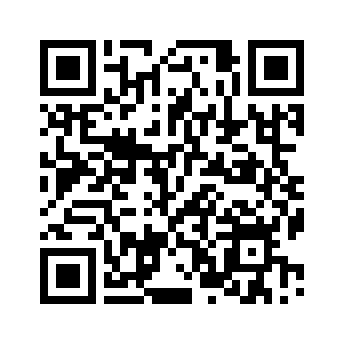

In [55]:
demo_qr_code()

<center><figure>
  <img src="demo-url.png" alt="Demo URL QR-Code">
</figure></center>



<h1 style='color:white'>.</h1>